# NOAA: EDA to BAA Severity Level Supervised Learning Model

Within this notebook we explore the datasets provided by NOAA (National Oceanic and Atmospheric Administration) where we pull a total of 12 datasets across 4 different regions divided evenly int three stations each. Our goal is to do to a multi-step EDA to understand the data first at a granular station-level, then move onto a regional analysis. We aim to build a supervised learning model for predicting coral bleaching severity based on the time series SST (Sea Surface Temperature) data provided by NOAA.

An extended goal, to be considered following the training of a supervised model would be to understand the principles of an ARIMA model and attempt to build a unsupervised forecasting model predicts temperature dependant future bleaching risks and severities for corals at a global scale.

In [ ]:
# Standard Libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import joblib
import sys

sys.path.append('..')

# Custom Tools
from load import load_noaa_station_data
from utils import create_noaa_date_column, create_noaa_seasonal_column, convert_to_numeric
from scipy.stats import zscore

# Wrangling tools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Regression Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

The official list of NOAA data can be found from:

[NOAA Regional Data](https://coralreefwatch.noaa.gov/product/vs/data.php)

We have carefully selected a broad range of datasets from NOAA. Within each dataset we can expect to have approxiamtely up to 14,000 rows when merged across all 4 regions of 3 stations, we measured around 177,000 rows of data. 

The NOAA have done a fantastic job of capturing SST's at a global scale supporting measurements along with other metrics, dating back to 1985 to the present date consistently, so we can expect to be working at a daily spread for the data.

[NOAA Data Point Descriptions](https://coralreefwatch.noaa.gov/product/vs/description.php#ascii)

In [55]:
# NOAA dataset
# selected 4 regions with 4 stations each
urls = [
    # Great Barrier Reef Region
    "https://coralreefwatch.noaa.gov/product/vs/data/gbr_far_northern.txt", # No stress (Static)
    "https://coralreefwatch.noaa.gov/product/vs/data/torres_strait.txt", # No stress (Static)
    "https://coralreefwatch.noaa.gov/product/vs/data/gbr_northern.txt", # No stress (Static)
    
    # Polynesia Region
    "https://coralreefwatch.noaa.gov/product/vs/data/samoas.txt", # Bleaching Watch (Static)
    "https://coralreefwatch.noaa.gov/product/vs/data/hawaii.txt", # No stress (Static)
    "https://coralreefwatch.noaa.gov/product/vs/data/southern_cook_islands.txt", # No stress (Static)
    
    # Caribbean Region
    "https://coralreefwatch.noaa.gov/product/vs/data/nicaragua.txt", # Bleaching Warning (Static)
    "https://coralreefwatch.noaa.gov/product/vs/data/panama_atlantic_east.txt", # Bleaching Warning (Static)
    "https://coralreefwatch.noaa.gov/product/vs/data/jamaica.txt", # Bleaching Warning (Static)

    # South Asia Region
    "https://coralreefwatch.noaa.gov/product/vs/data/kerala.txt", # Alert level 2 (Static)
    "https://coralreefwatch.noaa.gov/product/vs/data/eastern_sri_lanka.txt", # Bleaching Watch (Static)
    "https://coralreefwatch.noaa.gov/product/vs/data/gulf_of_kutch.txt", # Bleaching Watch (Static)
]

## Notebook Overview

This notebook can be broken down into four major sections: Single-Set Analysis, Multi-Set Analysis, Feature Set Engineering, and Supervised Learning. Each section is divided into sub-sections which we define at the beginning of each major section.

### Contents

- Single Set Analysis: This section of the notebook contains the EDA at a granular single station level

- Multi Set Analysis: This section takes the learnings from the Single Set Analysis and scales to a multi-regional level to explore the data for multiple regions and stations

- Feature Set Engineering: After completing the EDA phase it is within this section that we handle feature engineering and prepare the training data.

- Supervised Learning: This section of the notebook takes the processed data from the previous section and brings our supervised BAA severity level predictor model to life

## Single Set Analysis

Covers the first major section to our project where we analyse NOAA's data at a station level.

### Sub Sections:

- Sub-section 1.1: Data Sanity check

- Sub-section 1.2: Correlations Analysis

- Sub-section 1.3: Distributions Analysis

- Sub-section 1.4: Seasonal Fluctuation Analysis

- Sub-section 1.5: Time-Series Pattern Analysis

### Sub-section 1.1: Data Sanity Check

Before we dive into any form of analysis, it was important that we ran quick sanity check for the dataset that we pulled.

We have already pre-defined a function under the load.py file in order to extract the data completely in its original state where we load the core pre-processed data into a data frame under ***station_df***

We do this for the first set in the list to load and read:

In [3]:
station_df = load_noaa_station_data(urls[0])
print(station_df.head())

   YYYY  MM  DD  SST_MIN  SST_MAX SST@90th_HS SSTA@90th_HS 90th_HS>0  \
0  1985  01  01  28.8200  29.2500     29.0300       0.7797    0.5600   
1  1985  01  02  28.8000  29.3300     29.0200       0.7135    0.5500   
2  1985  01  03  28.8000  29.2700     29.0300       0.7219    0.4900   
3  1985  01  04  28.7500  29.3100     29.0300       0.7103    0.4600   
4  1985  01  05  28.7100  30.6700     29.6400       1.3177    1.0500   

  DHW_from_90th_HS>1 BAA_7day_max           Station              Region  \
0             0.0000            0  Far Northern GBR  Great Barrier Reef   
1             0.0000            0  Far Northern GBR  Great Barrier Reef   
2             0.0000            0  Far Northern GBR  Great Barrier Reef   
3             0.0000            0  Far Northern GBR  Great Barrier Reef   
4             0.0000            0  Far Northern GBR  Great Barrier Reef   

   Latitude  Longitude  
0   -12.675      144.1  
1   -12.675      144.1  
2   -12.675      144.1  
3   -12.675     


From a high-level perspective, before we get into the column details and what they mean, it is important to understand exactly what the set contains:

- ***environmental condition measurements*** - temperatures of the sea surface (columns SST_MIN, SST_MAX, SST@90th_HS)

- ***temperature anomalies*** - how much warmer/cooler the temperatures was found to be in comparisons to averaged values(columns SSTA@90th_HS)

- ***bleaching risk level*** - An integer scale from 0 to 7 ascending in the severity of bleaching levels as can be seen by the column BAA__7day_max

Now, in order to define the space that we are working in, let us outline each column stated above as a prerequisite and it's definitions:

- YYYY, MM, DD - The year, month, and date 

- ***SST_MIN*** - The minimum sea surface temperature for a specific date

- ***SST_MAX*** - The maximum sea surface temperature for a specific date

- ***SST@90th_HS*** - The temperature at the 90th percentile for a specific date

- ***SSTA@90th_HS*** - The temperature anomaly at the 90th percentile
  
  - What is a SSTA (Sea Surface Temperature Anomaly)? The difference between the observed sea surface temperature (SST) and the long-term average SST for that location and time of year.
  
  - A positive anomaly means the water is warmer than usual, while a negative anomaly means it's cooler than usual.

- ***90th_HS>0*** - The daily hotspot value at the 90th percentile - how much above the bleaching threshold the temperature is in comparison to the max monthly mean

  - Hot Spot: This can expressed as the SST (Seas Surface Temperature) MAX - maximum monthly mean

- ***DHW_from_90th_HS>1*** - Degree heating weeks meaning the sum of HotSpot values above 1°C over the last 12 weeks in the 90th percentile (top 10%)

  - DHW: This is the accumulated /sum of hotspot values that exceed 1°C over the last 12 weeks

- ***BAA_7day_max*** - The bleaching severity level stored as an integer ranging from 0 to 4 for marking the severity of the bleach:
  - 0 = No Stress
  - 1 = Bleaching Watch
  - 2 = Bleaching Warning
  - 3 = Alert Level 1
  - 4 = Alert Level 2 (severe)

As always, we should start our EDA process with a basic null check for all column values and the datatypes so that we can get a first insight to what we are working with:

In [4]:
print(station_df.isna().sum()) 
print(station_df.dtypes)


YYYY                  0
MM                    0
DD                    0
SST_MIN               0
SST_MAX               0
SST@90th_HS           0
SSTA@90th_HS          0
90th_HS>0             0
DHW_from_90th_HS>1    0
BAA_7day_max          0
Station               0
Region                0
Latitude              0
Longitude             0
dtype: int64
YYYY                   object
MM                     object
DD                     object
SST_MIN                object
SST_MAX                object
SST@90th_HS            object
SSTA@90th_HS           object
90th_HS>0              object
DHW_from_90th_HS>1     object
BAA_7day_max           object
Station                object
Region                 object
Latitude              float64
Longitude             float64
dtype: object


We seem to face no issues with the null check as the dataset seems to show quiet consistent across. One thing that we do face as an issue though is that our numerically expected data types are of type object. Let us quickly fix this to numerical values:

In [ ]:
numeric_cols = ['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', 
                '90th_HS>0', 'DHW_from_90th_HS>1', 'BAA_7day_max']

station_df = convert_to_numeric(station_df, numeric_cols)

print('data types of columns: ', station_df.dtypes)

data types of columns:  YYYY                   object
MM                     object
DD                     object
SST_MIN               float64
SST_MAX               float64
SST@90th_HS           float64
SSTA@90th_HS          float64
90th_HS>0             float64
DHW_from_90th_HS>1    float64
BAA_7day_max            int64
Station                object
Region                 object
Latitude              float64
Longitude             float64
dtype: object


Now that we are working with the correct types, lets do a quick duplication check:

In [6]:
print('duplicate rows: ',  station_df.duplicated().sum())

duplicate rows:  0


### Sub-section 1.2:  Correlations Analysis

One of the first things that we thought would be ideal to get an insight into was the correlations between each of the values. Ofcourse, since our target column is already known to be the BAA_7day_max, we where particularly keen to find any strong positive or negative correlations that may have been shown between certain values and the BAA_7day_max

Our goal overall was to identify any interesting relationships between variables that may be of use to us, so we decided to do analyse the correlations between all values at once on a heatmap using seaborn:

Correlation Matrix:
                     SST_MIN   SST_MAX  SST@90th_HS  SSTA@90th_HS  90th_HS>0  \
SST_MIN             1.000000  0.971276     0.962997      0.473256   0.650749   
SST_MAX             0.971276  1.000000     0.987190      0.503156   0.664221   
SST@90th_HS         0.962997  0.987190     1.000000      0.524322   0.675240   
SSTA@90th_HS        0.473256  0.503156     0.524322      1.000000   0.523226   
90th_HS>0           0.650749  0.664221     0.675240      0.523226   1.000000   
DHW_from_90th_HS>1  0.460431  0.447161     0.457217      0.366442   0.511451   
BAA_7day_max        0.692849  0.698133     0.707982      0.456699   0.847004   

                    DHW_from_90th_HS>1  BAA_7day_max  
SST_MIN                       0.460431      0.692849  
SST_MAX                       0.447161      0.698133  
SST@90th_HS                   0.457217      0.707982  
SSTA@90th_HS                  0.366442      0.456699  
90th_HS>0                     0.511451      0.847004  
DHW_from_

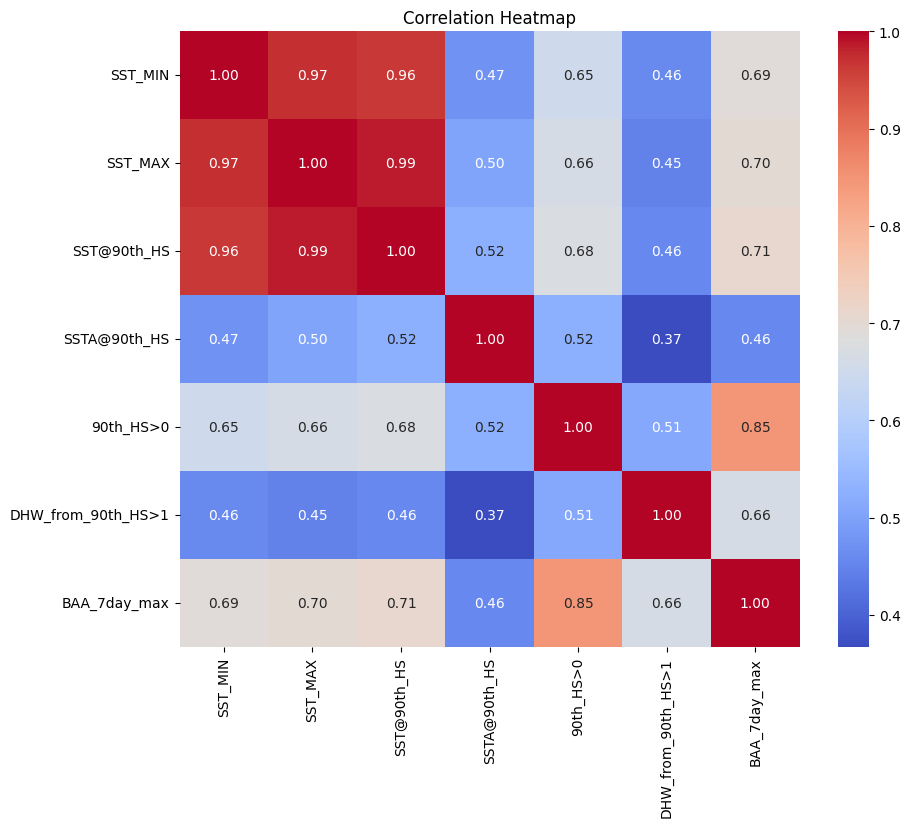

In [7]:
correlation_cols = ['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', '90th_HS>0', 'DHW_from_90th_HS>1', 'BAA_7day_max']
correlation_df = station_df[correlation_cols].dropna()
correlation_matrix = correlation_df.corr()
print("Correlation Matrix:")
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

***Key takeaways***

Listing in the order of strength and importance in terms of correlations, we seem to see quite few number of positive correlations in our single station pull:

-  ***90th_HS>0***: Straight off the bat, we can see that the this value has the strongest correlation between to the BBA score. We see a strong positive score where r ≈ 0.85. We can deduce from this that the when the SST exceeds the bleaching threshold in the top 10% the BAA score also is heavily effected

- ***SST@90th_HS***: We can also see a strong positive correlation here of r ≈ 0.71 in relation with the BAA levels. This makes sense and is honestly quite intuitive as it tells us that when the temperature of the sea surface rises to reach the top 10%, we can also expect to see an increase on the BAA severity levels

- ***DHW_from_90th_HS > 1***:  Another positive correlation coming in at r ≈ 0.66. We can notice that with a score of 0.66 indicates a weaker yet positive correlation to the BAA score. Considering that this is the DHW, we believe this tells us that the accumulated heat stress over time does indeed have a relationship with bleaching levels but not as importantly as the first two values stated above.

- ***SSTA@90th_HS***: A much weaker correlation compared to others, but not weak enough to be ignored, the SST anomalies column seems to show us r ≈ 0.46. This indicates to us that they may have some form of impact to the BAA levels but would need further investigations.

- ***SST_MIN & SST_MAX***: This was a tricky one to analyse. Indeed we can see that both show a decently strong positive correlation to the BAA levels but we can also see that they actually have incredibly high positive correlations with each other r ≈ 0.97. In data, this is what we call ***collinearity***. This is essentially something that we want to be careful of because it can actually confuse us during the analysis phase as it gets hard to see whether the bleaching levels is related to the MIN or the MAX. For those reasons, it is generally better to stick to the values that are derived from these variables!

### Sub-section 1.3: Distributions Analysis

No matter what set we work with, it is alway important to check distributions. The point of this step for us, is as usual, to see what sort of spread patterns are shown across the dataset. We want to know whether we are looking at any skewed or normal curves, check for outliers, and see if we can spot any patterns that may be of interest to us. 

First lets start by mapping all the distributions of each numerical value columns in a similar approach to our correlations anaylsis. This way it is just better to see the big picture from the start:

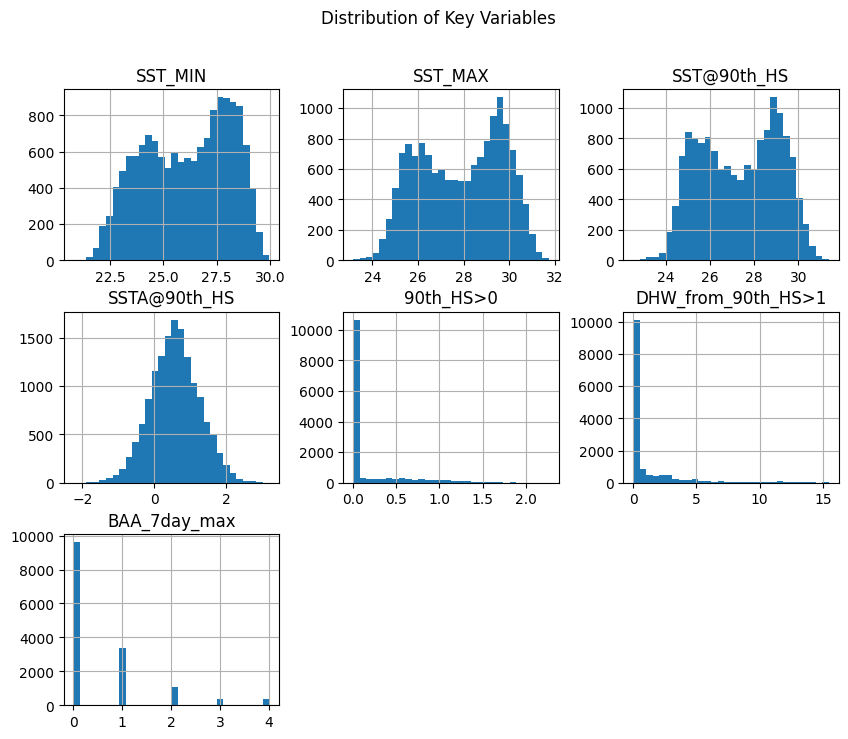

In [8]:
numeric_cols = ['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', '90th_HS>0', 'DHW_from_90th_HS>1', 'BAA_7day_max']
station_df[numeric_cols].hist(bins=30, figsize=(10, 8))
plt.suptitle('Distribution of Key Variables')
plt.show()

#### Key Insights

Immediately we can take take a look at this and see incredible skews on the 90th_HS>0, and the DHW_from_90th_HS>1 which makes sense to us because they are threshold values.

***HS in the top 10%***
To further explain, this is because the first 90th percentile (90th_HS>0) measures how much the SST (sea surface temperature) exceeds the bleaching threshold where > 0 shows above and <= 0 shows below. Since it’s a threshold value and bleaching events are rare, most of the time we can expect the SST to be below the bleaching threshold, so the extreme skew is no surprise to us.

***DHW***
Similar with the degree heating weeks, it measures the accumulated heat stress over the past weeks where we calculate it from the sum of daily temperature anomalies above the bleaching threshold over a rolling 12-week period. Again, coral bleaching values are rare, therefore we can expect to see many more zeroes than positive values in this columns distribution.

***Normal Distribution: SST Anomalies***
SST anomalies on the 90th percentile hotspot (SSTA@90th_HS) catches our attention as it seems to show us a normal distribution like bell curve, which we like to see. What this starts to tell us is that the temperature anomalies seem to be fairly stable and follow a predictable pattern and that they are not experiencing a lot change most of the time. To keep digging, there must be some logical reasoning behind why that is which makes us immediately want to do som further digging into it!

***Bimodal distributions: SST MIN, MAX, and 90th Percentile***
For the first row, we seem to see what we call bimodal distributions, meaning that we see two peaks in the distribution. As each of the three distributions are measuring the direct SST (Sea Surface Temperature) patterns, this suggests to us that this could quite likely be caused by the seasonal changes but it would be good to have a further look and confirm which we cover in our next seasonal analysis section.

Logically following these steps, we would want to confirm what we hypothesis in the last section to be true by further looking into the seasonal patterns which then brought us to the next sub-section of doing a seasonal analysis

### Sub-section 1.4: Seasonal Analysis

Following a clear logical step forward, we are brought to the next part of our single set analysis where we do some seasonal analysis based on the distributions results to test whether our hypothesis is true about the bimodal distributions and if see if we can get any further information. 

For the first step, it would make sense to do a bit of “feature engineering” and create the seasons column for the dataset by extracting the months and deducing values (please look at the utils.py to see function if curios):

In [9]:
create_noaa_seasonal_column(station_df)
print(station_df['Season'].head())

0    Winter
1    Winter
2    Winter
3    Winter
4    Winter
Name: Season, dtype: object


Now that we have added the season column, lets try plotting the grouped distributions to get a first view:

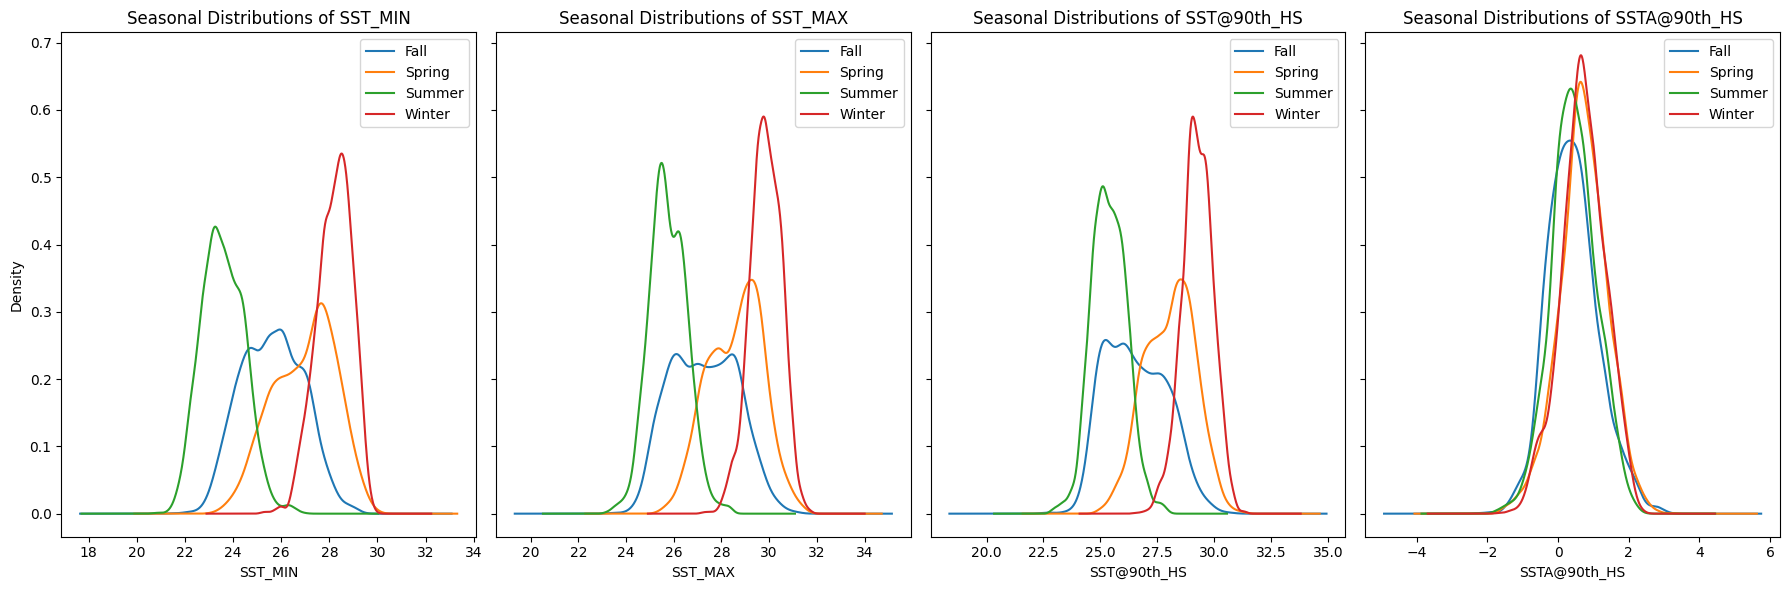

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(18, 6), sharey=True)

# For SST_MIN
station_df.groupby('Season')['SST_MIN'].plot(kind='kde', ax=axes[0], legend=True)
axes[0].set_title('Seasonal Distributions of SST_MIN')
axes[0].set_xlabel('SST_MIN')

# For SST_MAX
station_df.groupby('Season')['SST_MAX'].plot(kind='kde', ax=axes[1], legend=True)
axes[1].set_title('Seasonal Distributions of SST_MAX')
axes[1].set_xlabel('SST_MAX')

# For SST@90th_HS
station_df.groupby('Season')['SST@90th_HS'].plot(kind='kde', ax=axes[2], legend=True)
axes[2].set_title('Seasonal Distributions of SST@90th_HS')
axes[2].set_xlabel('SST@90th_HS')

# For SSTA@90th_HS
station_df.groupby('Season')['SSTA@90th_HS'].plot(kind='kde', ax=axes[3], legend=True)
axes[3].set_title('Seasonal Distributions of SSTA@90th_HS')
axes[3].set_xlabel('SSTA@90th_HS')

plt.tight_layout()
plt.show()

Very interesting indeed!

***SST minimum & maximum***

So from this, we can clearly tell that our hypothesis was true. The SST minimum and maximum distributions where in fact caused by the seasonal changes which is not too much of a surprise. 

***SST Anomolies at the 90th percentil hotspot*** 

What is even more exciting though is that the seasonal distributions for the SSTA@90th_HS seems to show a normal distribution like bell curve as we already saw from earlier but also regardless of when we group by the season. 

***Why is this so interesting to us?***

We want to study this a bit further because it differs from the other patterns despite being centered around the SST. This made us very curios as to what the anomaly could be representing and whether we where onto something.

***What does this mean?***

First of all, we need to understand that the SSTA@90th_HS is an **anomaly**, meaning it measures deviations from a long-term average for each location and time of year.

We next hypothesis that the lack of seasons effect in the SSTA@90th_HS distribution tells us that the anomaly calculation, as stated above, has actually removed the seasonal factor from the data. 

This actually could make it a useful variable for identifying unusual temperature events that can not normally be detected regardless of the season, and tells us that we should consider this column when training our model.

#### Further investigation

From this finding, we also wanted to further investigate specifically into the SSTA@90th_HS.

Furthermore to summarise a more practical understanding of the SSTA@90th_HS columns, we can say that when the 90th_HS increases, we are experiencing much warmer temperatures than what is expected which can ofcourse, cause for concern due to it being one of the factors involved in coral symbiotic algae release.

Since we already know we want to investigate this further, we could use some statistical skills for normal distributions together with intuition from the earlier statement to take a targeted focus into the upper percentile outliers for higher temperatures.

For the sake of covering both ends, let's get started and break them down for the upper and lower ranges into > 2 and < -2 as can be seen from the distribution above to cover all both the upper and lower percentile anomalies

In [11]:
upper_anomalies = station_df[station_df['SSTA@90th_HS'] > 2]
lower_anomalies = station_df[station_df['SSTA@90th_HS'] < -2]

# We use the absolute value and check > 2 for both upper and lower anomalies combined because |-2| = 2
lower_and_upper_anomalies = station_df[station_df['SSTA@90th_HS'].abs() > 2]

Alright, now that lets do a boxplot first to very easily try and spot any of the outliers, we will just do for all three so that it is easy to view in one go:

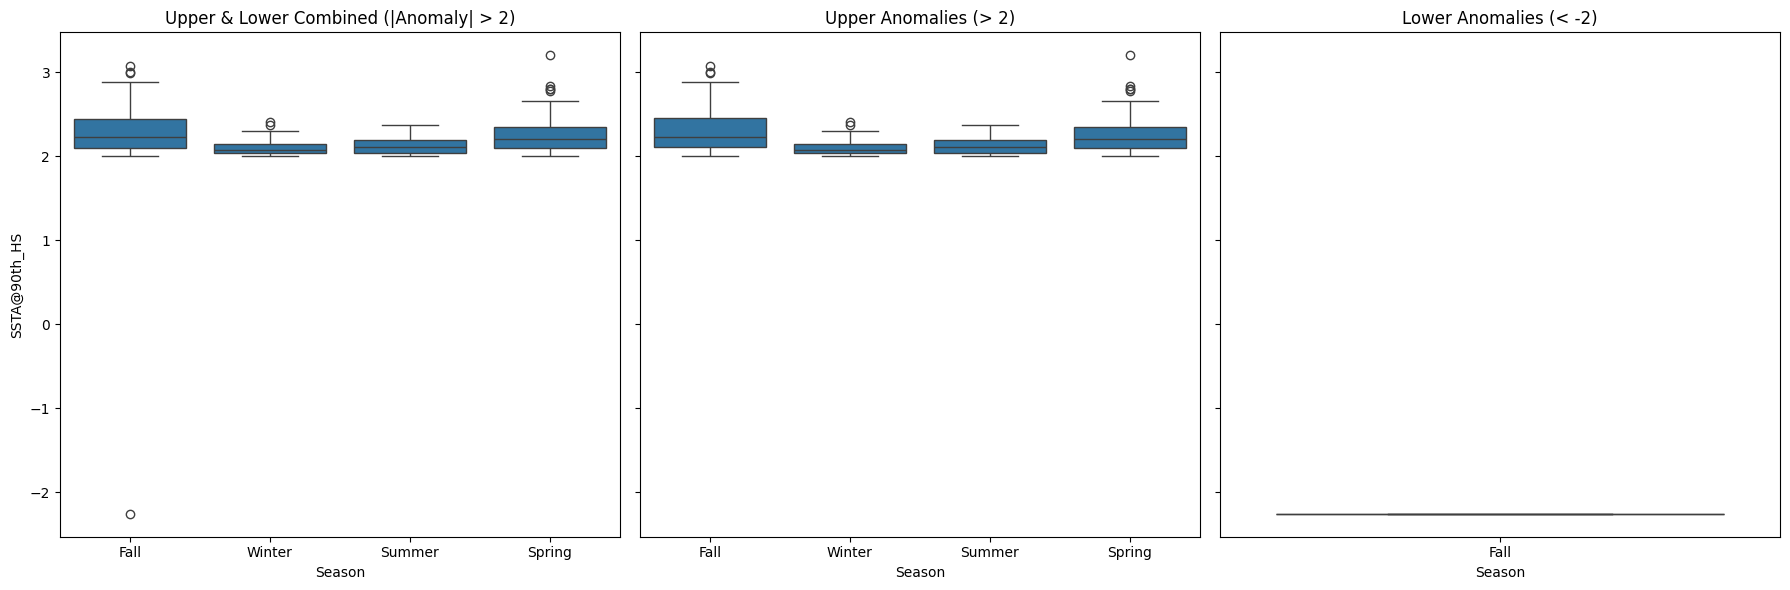

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# For Both
sns.boxplot(data=lower_and_upper_anomalies, x='Season', y='SSTA@90th_HS', ax=axes[0])
axes[0].set_title('Upper & Lower Combined (|Anomaly| > 2)')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('SSTA@90th_HS')

# For Upper only
sns.boxplot(data=upper_anomalies, x='Season', y='SSTA@90th_HS', ax=axes[1])
axes[1].set_title('Upper Anomalies (> 2)')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('')

# For lower only
sns.boxplot(data=lower_anomalies, x='Season', y='SSTA@90th_HS', ax=axes[2])
axes[2].set_title('Lower Anomalies (< -2)')
axes[2].set_xlabel('Season')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

As shown, only the upper anomalies show outliers whereas the lower anomalies show no outliers. This is great, lets focus on the upper range:

In [13]:
seasonal_stats = upper_anomalies.groupby('Season')['SSTA@90th_HS'].agg(['mean', 'quantile'])
seasonal_stats['25th Percentile'] = upper_anomalies.groupby('Season')['SSTA@90th_HS'].quantile(0.25)
seasonal_stats['75th Percentile'] = upper_anomalies.groupby('Season')['SSTA@90th_HS'].quantile(0.75)

print(seasonal_stats)

            mean  quantile  25th Percentile  75th Percentile
Season                                                      
Fall    2.314420    2.2377         2.108225         2.452175
Spring  2.269883    2.2084         2.106500         2.353550
Summer  2.126132    2.1153         2.044150         2.190425
Winter  2.116130    2.0819         2.046925         2.154000


We now have a very clear vision on the IQR (interquartile range: 75th - 25th) between the four different seasons for the SSTA and can see which season tends to introduce the largest deviation in terms of the SST anomalies. We see the ranking to show the Fall season holding the largest IQR, followed by spring, summer, and winter.

*What can we learn from this?*

If what we where hypothesising about the upper anomalies leading to coral bleaching to be true, we can say from this that the Fall and Spring may represent higher-risk periods for coral bleaching due to their higher IQR for outliers. That is a huge takeaway!!

Since we have come as far as analyse the IQR's it would statistically make sen to also look into the z-scores that seasonal distributions may present us.

In [ ]:
station_df['SSTA_Z_Score'] = zscore(station_df['SSTA@90th_HS'])

print("Z-Score Statistics:")
print(station_df['SSTA_Z_Score'].describe())

extreme_anomalies = station_df[(station_df['SSTA_Z_Score'] > 3) | (station_df['SSTA_Z_Score'] < -3)]
seasonal_z_stats = station_df.groupby('Season')['SSTA_Z_Score'].agg(['mean', 'std', 'max', 'min'])

print("Seasonal Z-Score Statistics:")
print(seasonal_z_stats)

Z-Score Statistics:
count    1.475300e+04
mean    -3.082406e-17
std      1.000034e+00
min     -3.521090e+00
25%     -6.622975e-01
50%      4.047255e-02
75%      6.926131e-01
max      4.126456e+00
Name: SSTA_Z_Score, dtype: float64
Seasonal Z-Score Statistics:
            mean       std       max       min
Season                                        
Fall    0.112223  0.876189  2.700914 -2.836238
Spring  0.149520  0.993021  3.686626 -3.521090
Summer  0.028624  0.942283  2.815925 -3.030630
Winter -0.293438  1.111694  4.126456 -3.462335


/var/folders/80/4jxcwcs907q0q8344n74zylh0000gn/T/ipykernel_32176/2421502980.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_df['SSTA_Z_Score'] = zscore(station_df['SSTA@90th_HS'])


#### Key Insights

What is a z-score? It is simply the measure of how far away we are from the mean. So basically a z-score of means that we are exactly average, > 0 would mean we are warmer than average and < 0 would mean we are colder than average

When we apply this knowledge to our results:

- ***Fall***: Shows us a z-score of 0.11 hinting to us that thermal anomalies are actually a bit above average. 

- ***Winter***: Gives us the lowest z-score of -0.29 together with the highest standard deviation of 1.11. All we can really say from this we think is that while the water is usually colder, it would not be a surprise to see a spike in temperature

- ***Spring***:  Spring on the other hand gives us the highest positive z-score of 0.15 together with some pretty high min and max (outliers).

- ***Summer***: Represents the most normal/neutral out of all the seasons with a z-score of 0.02 telling us that is the most close to the average. We can say that Summer is probably the most stable out of all the seasons

### Sub-section 1.5 Time-series Pattern Analysis

Lastly, for the single set EDA, we decided to do a time-series analysis on our set. The reason for this being that up until this point, we have analysed correlations which helped us understand what datapoints effected the bleaching severity the most, distributions which then helped us visualise the spread of those points and lead us down the path of making seasonal pattern analysis due to the presence of bimodal distribution in the SST values, which ultimately lead us to study why the SST anomalies in the 90th percentile was showing us a non-seasonally effected normal distribution.

At this point, we wanted to bring all of these things together and look at the long-term picture and see if we can find any trends over periods of time which could give us a better insight into the coral bleaching risks. 

It would also be nice to dig a bit deeper into our point about the SST anomalies and see if they actually related to the bleaching events in any other interesting ways:

We can take a targeted approach here of:

 - Plotting SST_MIN, SST_MAX, SSTA@90th_HS, BAA_7day_max over a period of time to see any interesting trends.

 - Decompose time-series data to separate trends, seasonality, and residuals.

First things first, let's make our life easier and add a concatenated Date column so that we can see the Dates in an ISO format. NOAA returns their datasets in the format of: YYYY, MM, DD each as their own column of type objects.

In [15]:
create_noaa_date_column(station_df)

Now plot all using over the newly created Date column to see the long-term effects of each value:

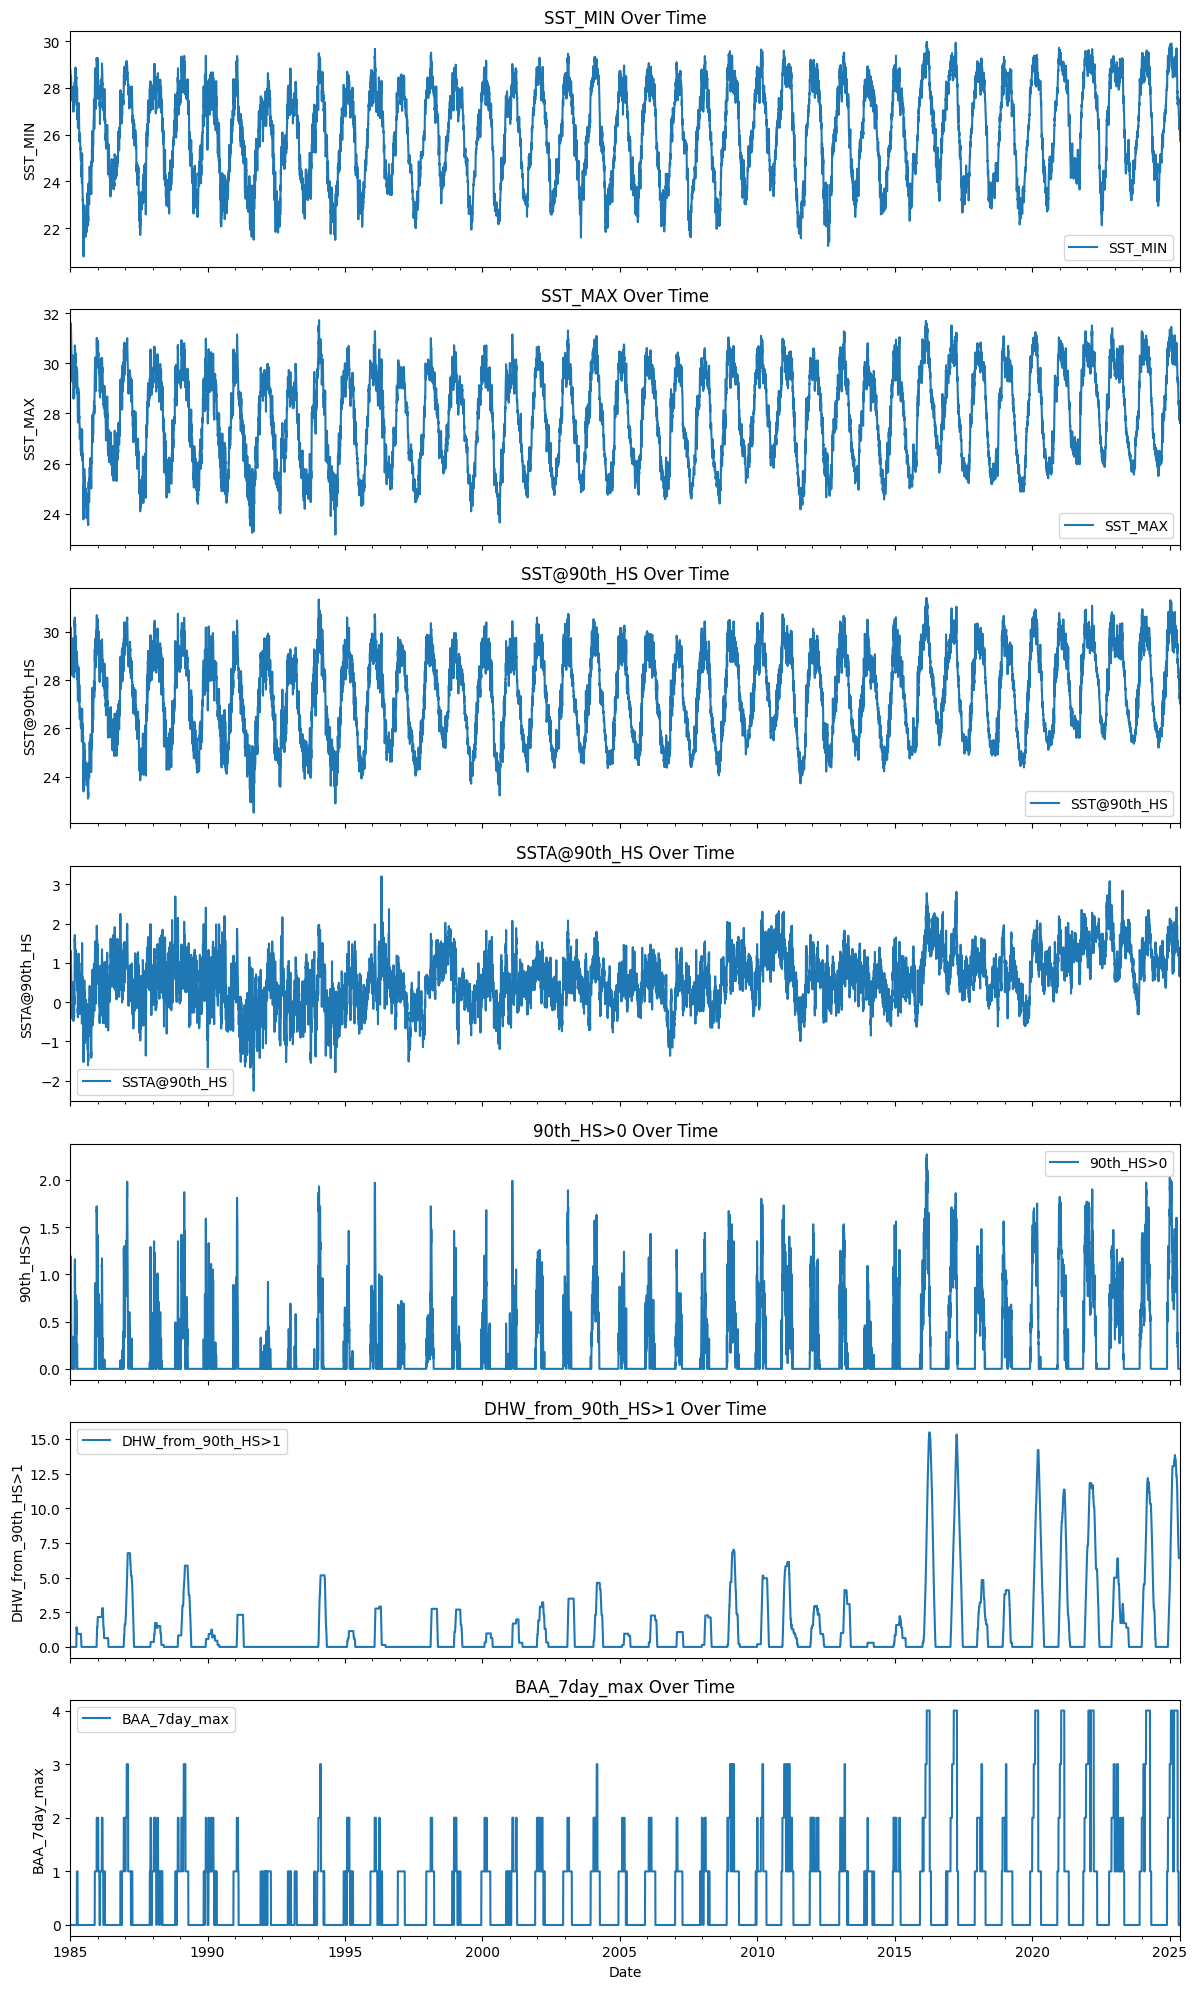

In [16]:
variables_to_plot = ['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', 
                     '90th_HS>0', 'DHW_from_90th_HS>1', 'BAA_7day_max']

fig, axes = plt.subplots(len(variables_to_plot), 1, figsize=(12, 20), sharex=True)

for i, var in enumerate(variables_to_plot):
    station_df.plot(x='Date', y=var, kind='line', ax=axes[i])
    axes[i].set_title(f'{var} Over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

Ok, we do seem to see some pattern across the SST anomalies here but it's a bit hard to directly look at multiple graphs at the same time and try to determine overlaps for pattern trends.

After a bit of research on how generic time-series analysis is done and digging through some online examples, we determined that we could use something called cross-correlation analysis here. 

A cross-corelation analysis can be used to measure the lagged relationships between two variables. What we mean by this is basically a check to see whether a change in one variable effects a change in another, and if so, how much time did it take. 

Lets take a look at the SST anomalies vs the bleaching severity first as we have had the most anticipation for those values:

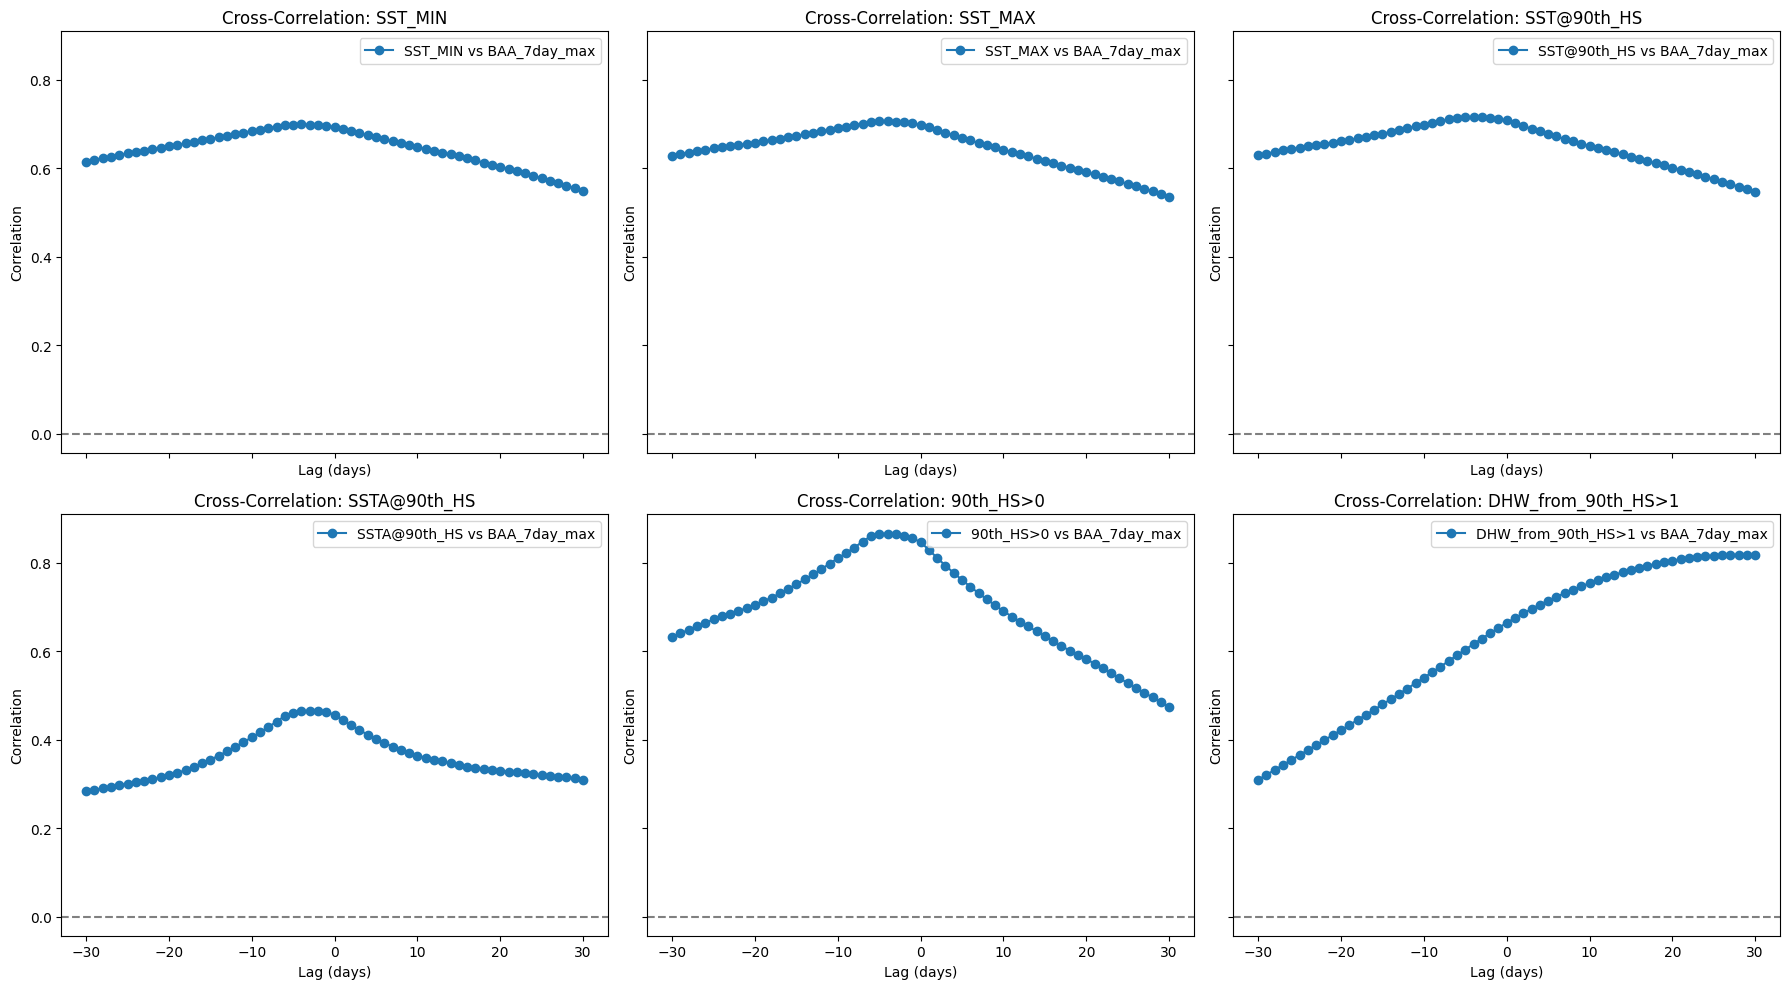

In [17]:
station_df = station_df.sort_values('Date')


variables = ['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', '90th_HS>0', 'DHW_from_90th_HS>1']

lags = np.arange(-30, 31)  # Test lags from -30 to +30 days
baa_7day_series = station_df['BAA_7day_max'].fillna(0)

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, var in enumerate(variables):
    series = station_df[var].fillna(0)
    cross_corr = [series.corr(baa_7day_series.shift(lag)) for lag in lags]
    
    axes[i].plot(lags, cross_corr, marker='o', label=f'{var} vs BAA_7day_max')
    axes[i].set_title(f'Cross-Correlation: {var}')
    axes[i].set_xlabel('Lag (days)')
    axes[i].set_ylabel('Correlation')
    axes[i].axhline(0, color='gray', linestyle='--')
    axes[i].legend()

plt.tight_layout()
plt.show()

***Interpretation***

It is a bit hard to see just from the graphs but we are basically trying to focus into the peaks. This is because we represent the correlations on the y-axis followed by the time lag on the x-axis, which means that if we focus into the exact time lag measure of when the correlation is the highest, we can see any time delays between bleaching levels and it relationship with the respective values. In this case a negative value would actually indicate a predictive factor of showing early signs of prediction before the bleaching events actually occur. 

Another key detail that we want to look into here is the sharpness of the peaks as that can represent to us the accuracy of the time lag scores that we are seeing. Meaning how precise are these actually showing the time lag for the correlations.

Lets get into the details and actually look at the values these graphs are showing:

In [18]:
for var in variables:
    series = station_df[var].fillna(0)
    cross_corr = [series.corr(baa_7day_series.shift(lag)) for lag in lags]
    max_corr = max(cross_corr, key=abs)  
    optimal_lag = lags[cross_corr.index(max_corr)]
    print(f"Variable: {var}, Max Correlation: {max_corr:.3f}, Optimal Lag: {optimal_lag} days")

Variable: SST_MIN, Max Correlation: 0.699, Optimal Lag: -4 days
Variable: SST_MAX, Max Correlation: 0.706, Optimal Lag: -4 days
Variable: SST@90th_HS, Max Correlation: 0.716, Optimal Lag: -4 days
Variable: SSTA@90th_HS, Max Correlation: 0.465, Optimal Lag: -3 days
Variable: 90th_HS>0, Max Correlation: 0.866, Optimal Lag: -4 days
Variable: DHW_from_90th_HS>1, Max Correlation: 0.818, Optimal Lag: 28 days


***Detailed Insights***

The results show quite several important patterns:

- ***SST’s (min, max, 90th percentile HS)*** - Let’s group these into a single explanation for the sake of the time series results as we are focusing into the sea surface temperatures and the correlation results shown are all very close to each other with the same day lag values. All three results show us a time lag delay of -4 days and a correlation of approximately 0.70 which indicates that SST measurements ***around 4 days before bleaching*** are valuable insights to us and show strong prediction properties

- ***SSTA*** - Measurements of the SST anomalies in the 90th percentile shows a much lower correlation in comparison to the previous results where we see a r ≈ 0.46 with a time lag of -3 days. Yet, the time lag of -3 days does tell us that we can expect to see some early signs from the SSTA measurements 3 days prior but with less relational impact compared to the three pure SST values. Nonetheless we still see a sharp peak which is a good indication of accuracy in predictions and is likely a solid value for us to leverage 

- ***90th_HS>0*** - Gave us the highest correlation result out of all values with a -4 day lag. This was ofcourse expected from our earlier analysis of the correlations exploration as we knew the 90th percentile HS had the highest correlation. This tells us that we can expect to see strong early signs from looking into the 90th HS prior to bleaching events. What is very important is that we looked into the time as the ***sharp peak*** from the graph earlier also tells us that the timing precision is in fact excellent.

### Single-Set Conclusion

This section of our EDA procedure has left us with some very valuable insights that we want to continue to explore in the next section. 

In conclusion, we found multiple strong relationships between certain values and the bleaching severity scores where we did an in-depth analysis into each part and drew conclusions as to what they meant. 

We where lead down a logical curiosity path after loading the distributions of each values to analyse what they meant and create a hypothesis of seasonal fluctuations that had an effect on BAA severity levels, discovering the SST anomalies where in fact: not being effect by the seasonal changes and gained more insights to what that meant as shown by the normal distribution. 

Lastly we did a time-series analysis where we where able to visualise and grasp the exact correlations and time lags to draw estimated conclusions for predictive factors of what early signs of coral bleaching can look like.

## Multi-Set Analysis: Global Scale Multi-Region

We've done some comprehensive analysis on a single set, diving deeply into a specific station and drawing valuable conclusions that will come heavily into play for when we train the models. Let's now do part two of our EDA procedure and combine different datasets across different regions as our last step before model training in order to analyse coral bleaching factors at a global scale:

### Sub Sections:

- Sub-section 2.1: Data Sanity check

- Sub-section 2.2: Multi-Regional Correlations & Distributions Analysis 

- Sub-section 2.3: Multi-Regional Seasonal Fluctuation Analysis

- Sub-section 2.4: Discovering Non-Linearity

- Sub-section 2.5: Multi-Region Time-Series 

***NOAA multi-region pull pipeline***

First we need to combine our station datasets. This would be straight forward as we have already extracted the pulling logic to it's own function so we can just run a quick custom data pipeline where we iterate through the list of stations by different regions, apply the feature engineering's of creating the date and the season columns, and ultimate convert the object values to usable numerical values

In [59]:
all_stations_data = []

for url in urls:
    try:
        station_df = load_noaa_station_data(url)
        station_name = station_df['Station'].iloc[0]
        print(f"Loaded {station_name} with {len(station_df)} records")
        all_stations_data.append(station_df)
    except Exception as e:
        print(f"Error loading {url}: {str(e)}")


if all_stations_data:
    combined_regions_df = pd.concat(all_stations_data, ignore_index=True)
    
    create_noaa_date_column(combined_regions_df) # Create date column since we already know we need it
    
    numeric_cols = ['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', 
                    '90th_HS>0', 'DHW_from_90th_HS>1', 'BAA_7day_max']
    
    existing_numeric_cols = [col for col in numeric_cols if col in combined_regions_df.columns]
    
    for col in existing_numeric_cols:
        combined_regions_df[col] = pd.to_numeric(combined_regions_df[col], errors='coerce')
    
    create_noaa_seasonal_column(combined_regions_df) # Create seasonal column since we already know we need it
   
    combined_regions_df.to_csv('../../data/noaa/pulled_data/coral_reef_data_combined.csv', index=False)
    print("\nCombined dataset saved to 'coral_reef_data_combined.csv'")
else:
    print("no stations loaded.")

Loaded Far Northern GBR with 14754 records
Loaded Torres Strait with 14752 records
Loaded Northern GBR with 14754 records
Loaded Samoas with 14753 records
Loaded Main Hawaiian Islands with 14754 records
Loaded Southern Cook Islands with 14752 records
Loaded Nicaragua with 14754 records
Loaded Panama Atlantic East with 14754 records
Loaded Jamaica with 14754 records
Loaded Kerala, India with 14754 records
Loaded Eastern Sri Lanka with 14754 records
Loaded Gulf of Kutch, India with 14754 records

Combined dataset saved to 'coral_reef_data_combined.csv'


### Sub-section 2.1: Data Sanity Check

Let's do the usual, same data sanity check now for the combined multi-regional dataset. We should repeat the same process where we are simply looking for any null values and duplicated rows.

Take a first look and ensure that there where no data pull errors in out multi-regional pipeline that we just ran:

In [20]:
print(f"Total number of records: {len(combined_regions_df)}")
print(f"Columns in the combined dataset: {combined_regions_df.head()}")

Total number of records: 177031
Columns in the combined dataset:    YYYY  MM  DD  SST_MIN  SST_MAX  SST@90th_HS  SSTA@90th_HS  90th_HS>0  \
0  1985  01  01    28.82    29.25        29.03        0.7797       0.56   
1  1985  01  02    28.80    29.33        29.02        0.7135       0.55   
2  1985  01  03    28.80    29.27        29.03        0.7219       0.49   
3  1985  01  04    28.75    29.31        29.03        0.7103       0.46   
4  1985  01  05    28.71    30.67        29.64        1.3177       1.05   

   DHW_from_90th_HS>1  BAA_7day_max           Station              Region  \
0                 0.0             0  Far Northern GBR  Great Barrier Reef   
1                 0.0             0  Far Northern GBR  Great Barrier Reef   
2                 0.0             0  Far Northern GBR  Great Barrier Reef   
3                 0.0             0  Far Northern GBR  Great Barrier Reef   
4                 0.0             0  Far Northern GBR  Great Barrier Reef   

   Latitude  Longitud

Everything seems to be in order as expected and can see that the pull pipeline succeeded with the Season and Data columns already being generated that we knew we wanted to leverage thanks to initial single-set subsection.

Let us confirm the null checks and the duplicated rows that we just mentioned to see if we have introduced any new errors or have some missing NaN values in our combined data-set. We should also confirm the data-types as we included the type casting in our pipeline and would like to make sure that the conversion to numerical values has also succeeded in our pipeline:

In [21]:
print('duplicate rows: ',  combined_regions_df.duplicated().sum())
print(combined_regions_df.isna().sum()) 
print(combined_regions_df.dtypes)

duplicate rows:  0
YYYY                  0
MM                    0
DD                    0
SST_MIN               0
SST_MAX               0
SST@90th_HS           0
SSTA@90th_HS          0
90th_HS>0             0
DHW_from_90th_HS>1    0
BAA_7day_max          0
Station               0
Region                0
Latitude              0
Longitude             0
Date                  0
Season                0
dtype: int64
YYYY                          object
MM                            object
DD                            object
SST_MIN                      float64
SST_MAX                      float64
SST@90th_HS                  float64
SSTA@90th_HS                 float64
90th_HS>0                    float64
DHW_from_90th_HS>1           float64
BAA_7day_max                   int64
Station                       object
Region                        object
Latitude                     float64
Longitude                    float64
Date                  datetime64[ns]
Season                       

Datasets checks out with no null values and a clean record of no duplicated rows either. Data type are also in order as 64-point float types!

### Sub-section 2.2: Multi-Regional Correlations & Distributions Analysis

With everything in order, we can begin with our correlations and distributions analysis now at a multi-regional and station scale. 

***Section Target***
In this section, we try to assess want to learn from EDA part 1  and see if the correlations and distribution findings that we found there also applies at a multi-regional station scale. Meaning when we expand our scope to a global scale, are we still finding the same values to have similar levels of correlation and do our conclusions that we drew for seasonal fluctuations, peak seasons, and time-series lag show to be true?

***First Task***

First before we get to the good part and start mapping individual region distributions, it would be needed to create a regional grouping so that we can make individual region level analysis. We can also use the .describe() function to fast access to some useful statistics such as regional mean and standard deviation which would useful to see:

In [60]:
regional_summary = combined_regions_df.groupby('Region')[numeric_cols].describe()
print(regional_summary)

                    SST_MIN                                                   \
                      count       mean       std    min    25%    50%    75%   
Region                                                                         
Caribbean           44262.0  27.653693  0.925327  24.28  26.96  27.66  28.34   
Great Barrier Reef  44260.0  26.223421  2.000717  20.38  24.67  26.48  27.94   
Polynesia           44259.0  26.118541  1.945950  21.44  24.40  26.03  27.83   
South Asia          44262.0  27.143473  2.259285  17.09  26.48  27.70  28.61   

                           SST_MAX             ... DHW_from_90th_HS>1  \
                      max    count       mean  ...                75%   
Region                                         ...                      
Caribbean           30.66  44262.0  28.587857  ...             0.7886   
Great Barrier Reef  30.41  44260.0  27.806853  ...             1.1043   
Polynesia           30.68  44259.0  27.740207  ...             0.1443   
S

The first thing that we noticed here is the low BAA_7day_max's mean for the South Asia region in comparison to the Caribbean region. The reason for why we find this rather strange is because we expect the bleaching levels to be much higher on average within the South Asia region as we already knew from when we picked the dataset. (Please reference to the url list at the start of the book as that contains each stations severity level in code comments).

We hypothesis that the data is likely skewed due the high severity levels in the South Asia region which is causing the mean to become much lower in comparison to the Caribbean region.

Either way, lets make a start and visualise some distributions so that we can take a better look into the distributions of the different regions:

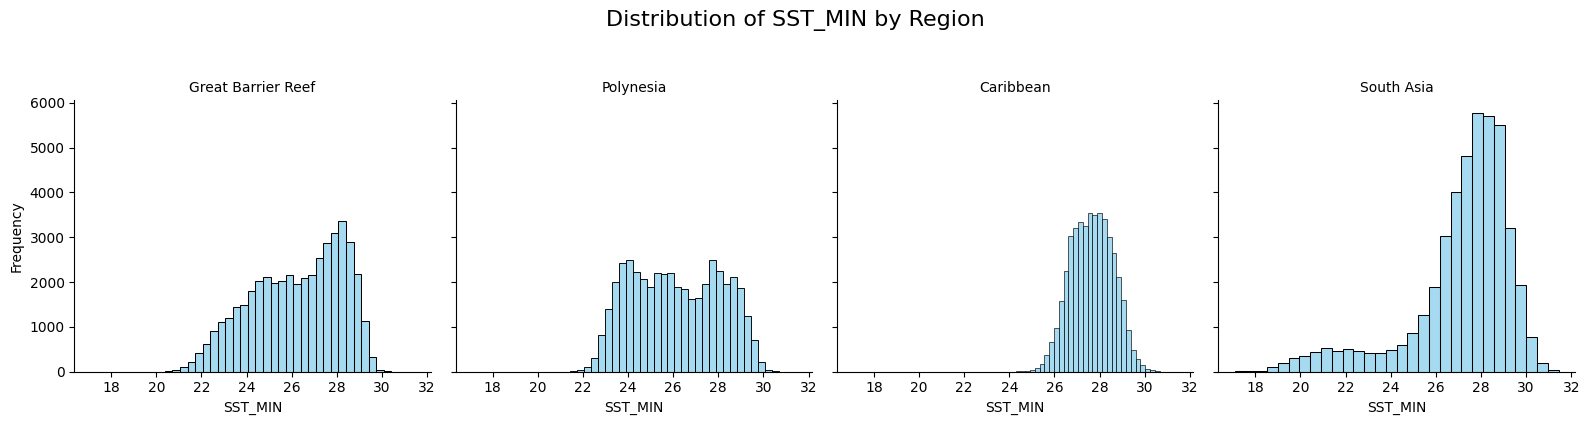

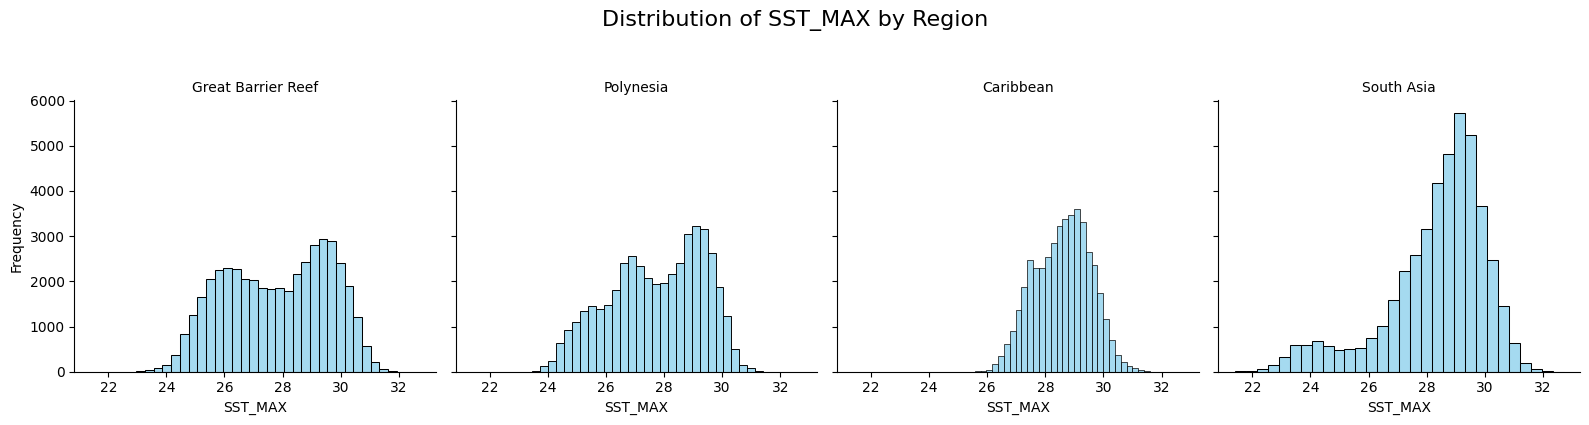

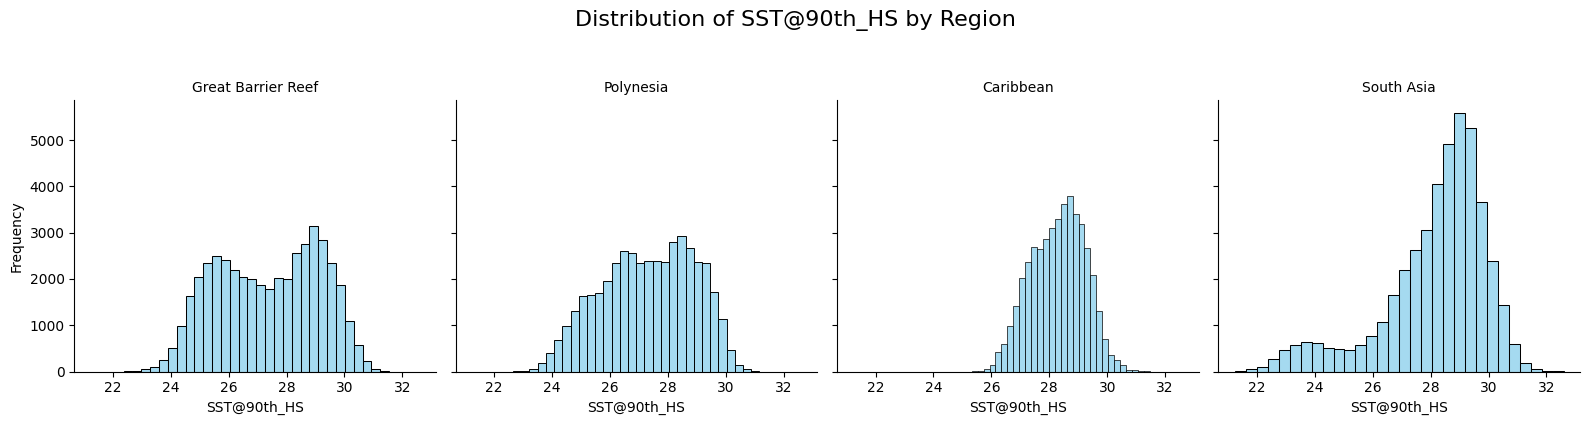

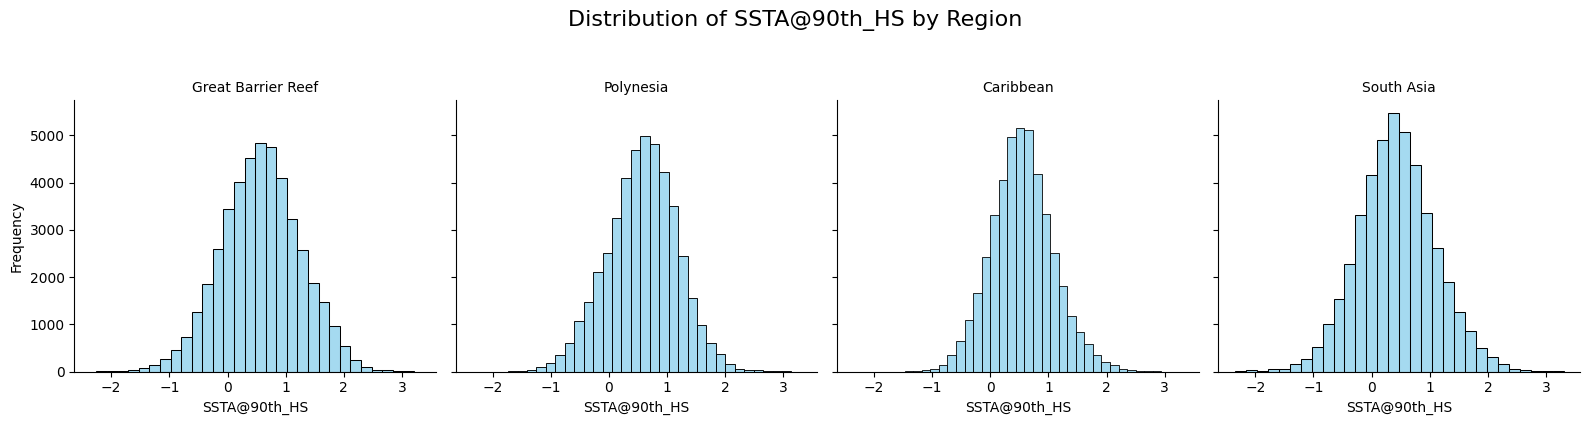

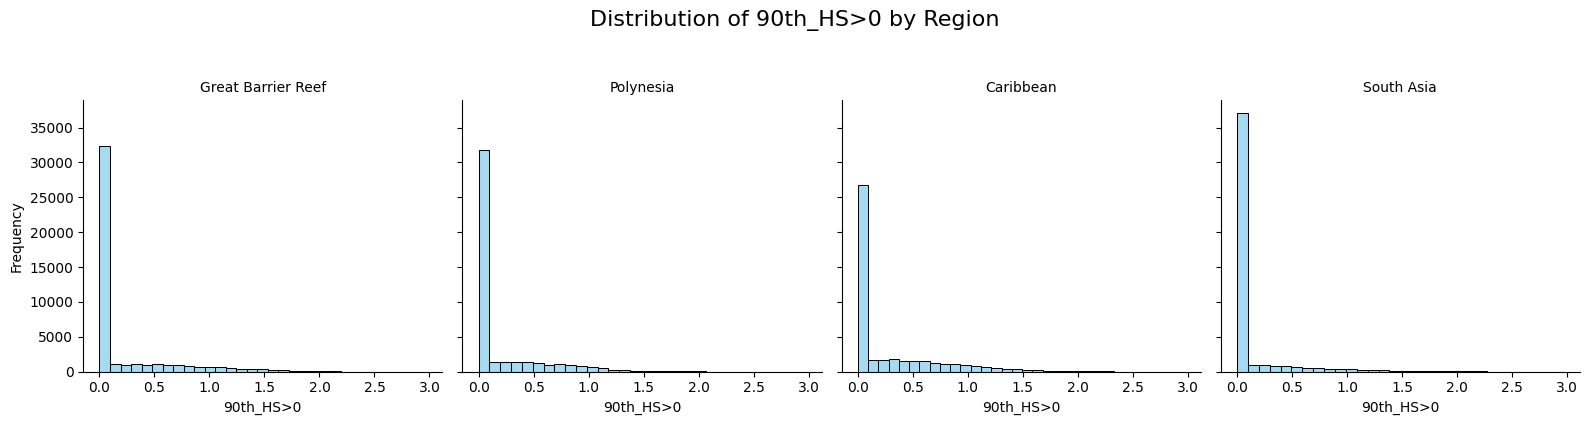

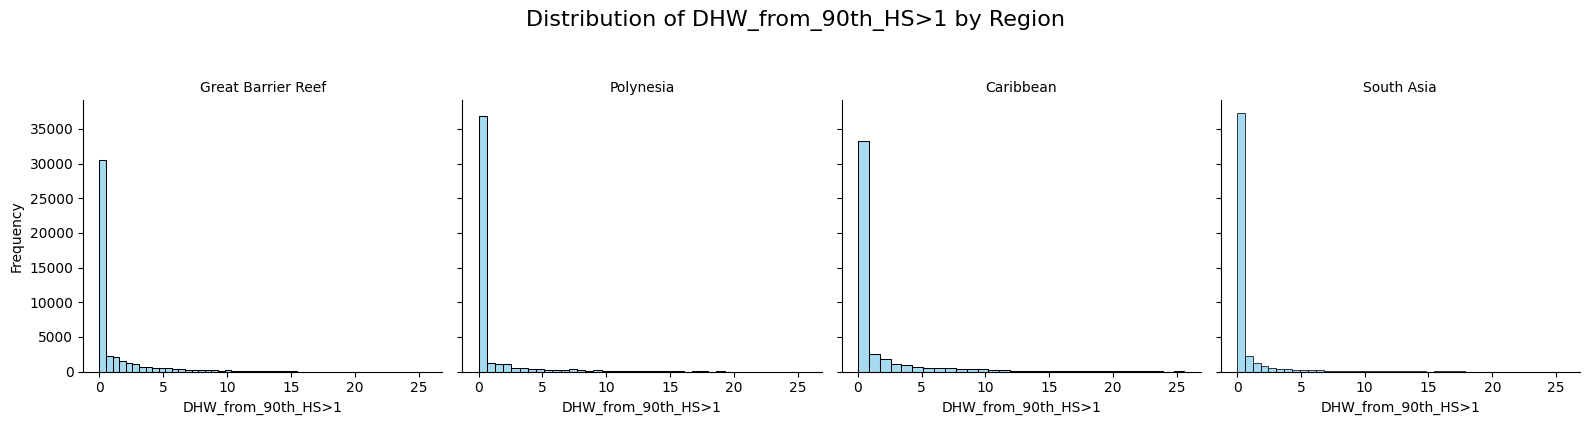

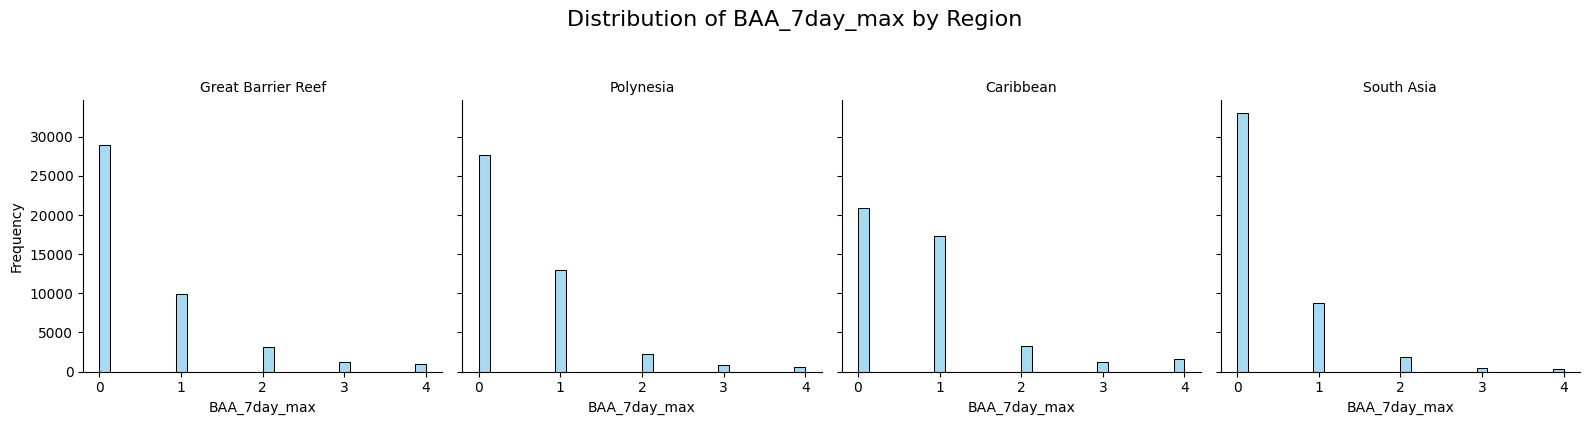

In [61]:
for col in numeric_cols:
    g = sns.FacetGrid(combined_regions_df, col="Region", col_wrap=4, sharex=True, sharey=True, height=4)
    g.map(sns.histplot, col, bins=30, kde=False, color="skyblue")
    g.set_titles("{col_name}")
    g.set_axis_labels(col, "Frequency")
    g.fig.suptitle(f"Distribution of {col} by Region", y=1.05, fontsize=16)
    
    plt.tight_layout()
    plt.show()

***Key Finding***

We can see quite clearly that the South Asia region has incredibly higher levels of SST fluctuations compared to the Caribbean region. 

In fact, there is so much of a difference that between the SST's that the Caribbean distribution shows an almost normal distribution consistently between the three SST columns signalling very stable and gradual levels of fluctuations. This makes us start to question and think that the temperature fluctuations between seasons might generally be a very big influencer to the bleaching levels of corals across different regions where having more fluctuations and unstable temperature changes could be leading to higher levels of bleaching severity risks. 

This is our first key insight immediately into the regional analysis, we should further confirm our hypothesis by looking into the seasonal. But first, lets take an intermediate step and quickly take a look at a correlations between the different values on a global scale between the different regions and see whether we can spot any differences in comparison to our sing-set analysis.

***Correlations***

We can immediately do the same as what we did in the first Single-Set Analysis section and plot the correlation heatmap using seabird heatmap() function. This will allow us to visualise the broad correlation analysis between all the values in the combined set that we are interested in:

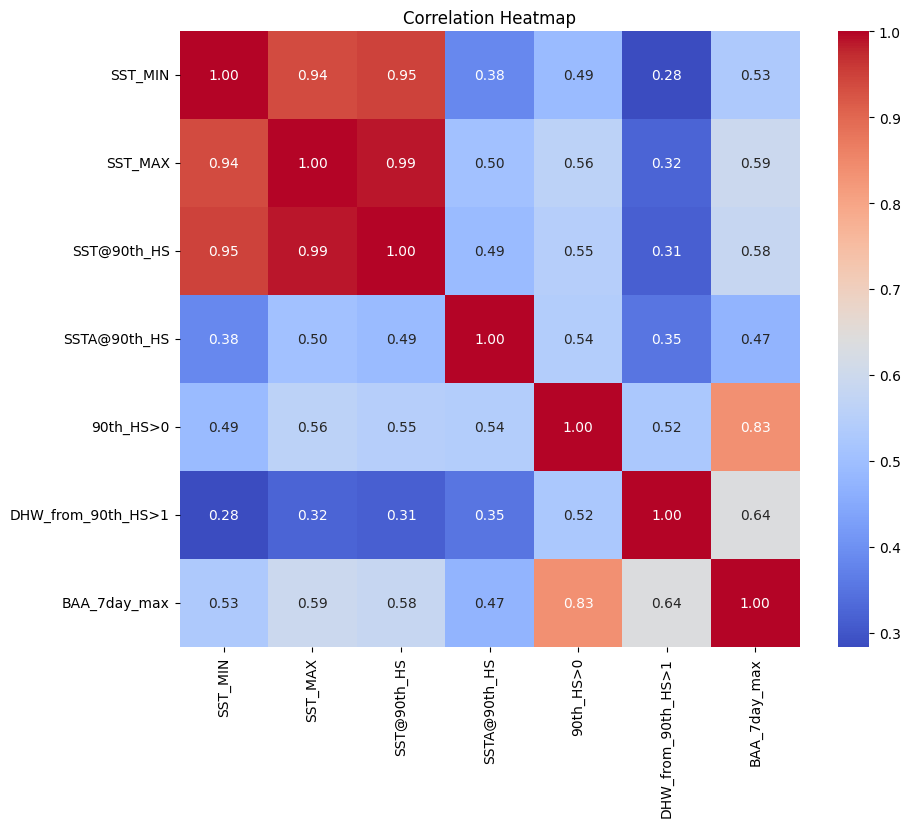

In [24]:
correlation_matrix = combined_regions_df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

***Findings***

The correlation heat map shows almost identical results to out single set analysis for the correlations between the data points. Although this does not provide us with any new exciting information, it is still great to know as it not only confirms our first findings to be valid, but also that the NOAA datasets are reliable.

#### Sub-section 2.2 Conclusion

Overall, we managed to gain a valuable insight into how seasonal changes and temperature fluctuations caused by them could lead us to some conclusions on severity bleaching risks. This was evidently shown by the Carribean's SST distribution showing a normal curve in comparison to South Asia which show us a heavy bimodal distribution. 

Even though we expanded to a global scope, we found that many of the key correlations between thermal stress and BAA severity remained consistent across regions. This allowed us to say with confidence that out first findings where accurate and that the NOAA dataset seems to shows us quite a bit of consistency across regions!

All in all, this sub-sections analysis suggests that not only the values but also the ***stability of SST conditions in the region*** may play an important role in predicting bleach severity outcomes, leading us beautifully into our next sub-section of multi-regional season analysis.

### Sub-section 2.3: Multi-Regional Seasonal Fluctuation Analysis

Let’s dig deeper on2.2’s hypothesis with some seasonal analysis at a global scale for the combined dataset. 

Hopefully from a larger multi regional and station scope, we will not only see seasonal trends across all the regions at once and draw a better picture for us, but give us more concrete answers to two main questions that we have coming into this subsection:

1. Was the Single-Set Analysis that we did for seasonal fluctuations also apply at a global scale? Even more so, did our findings of Fall likely having the most influence on BAA severity levels continue to be true at in the expanded scope? 

2. Was our hypothesis correct of the regions SST stability playing a role on BAA severity levels?

WE can begin our exploration by taking the code from our seasonal analysis earlier and applying it now on the multi-regional, global scope:

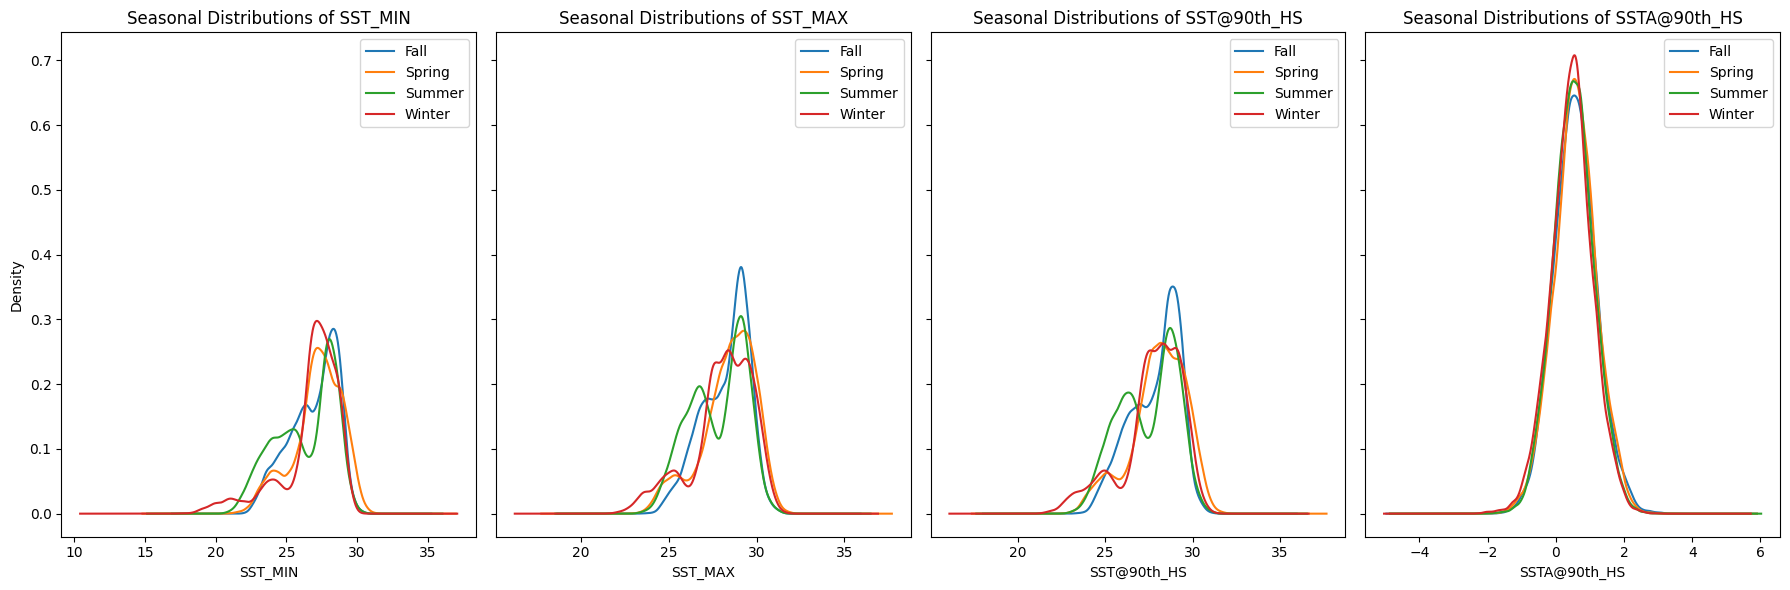

In [25]:
fig, axes = plt.subplots(1, 4, figsize=(18, 6), sharey=True)

# For SST_MIN
combined_regions_df.groupby('Season')['SST_MIN'].plot(kind='kde', ax=axes[0], legend=True)
axes[0].set_title('Seasonal Distributions of SST_MIN')
axes[0].set_xlabel('SST_MIN')

# For SST_MAX
combined_regions_df.groupby('Season')['SST_MAX'].plot(kind='kde', ax=axes[1], legend=True)
axes[1].set_title('Seasonal Distributions of SST_MAX')
axes[1].set_xlabel('SST_MAX')

# For SST@90th_HS
combined_regions_df.groupby('Season')['SST@90th_HS'].plot(kind='kde', ax=axes[2], legend=True)
axes[2].set_title('Seasonal Distributions of SST@90th_HS')
axes[2].set_xlabel('SST@90th_HS')

# For SSTA@90th_HS

combined_regions_df.groupby('Season')['SSTA@90th_HS'].plot(kind='kde', ax=axes[3], legend=True)
axes[3].set_title('Seasonal Distributions of SSTA@90th_HS')
axes[3].set_xlabel('SSTA@90th_HS')

plt.tight_layout()
plt.show()

### Key Findings & Sub-section 2.3 Conclusion

Yes, this clearly shows for us further confirmation of our earlier findings. We can see that across the seasonal fluctuations of the combined dataset, the dominant seasonal fluctuation for the SST is in fact: the Fall season! 

We can say that the Fall season is most likely much more sensitive and prone to some SST conditions that leads to coral bleaching which is actually a key takeaway in our analysis.

At this point, we seriously started to question the relationships of what is effecting the target column, in our case the BAA severity levels and whether we are working in a linear space or not!

From the information and insights that we have gathered so far, it is becoming increasingly evident that the relationship between SST and coral bleaching might **not** be linear. 


***Why?***

If bleaching severity could be described in linear space, we should theoretically see the response to rising SST as a constant increase in BAA severity as the SST increases since the model can be explained in y=mx + b.

However, we are clearly observing that the regions with more stable SST patterns (Caribbean) tend to show lower bleaching severity, while regions with greater SST fluctuations (like South Asia) demonstrate higher severity. 

Not only that, the seasonal changes and the SST fluctuations that are shown, as we saw in the Fall season, appears to have great influence on the BAA severity levels. This suggests to us that the seasonal changes and SST fluctuations could be just as important as raw temperature values! 

This all points towards a ***non-linear*** relationship, where bleaching risk might be accelerates rapidly once certain SST conditions are met. We just do not know to what extent the severity level increases at and we might be looking at accelerated bleaching risks once certain values are hit. 

This brings complexity and excitement into our project and was a huge finding for us. The clear intuitive step forward was for us to better understand the nature of this relationship.


### Sub-section 2.4: Discovering Non-Linearity


***Non-linear Space Introduction***

First lets just look at the SSTA. Why? Because the SSTA represents the deviations, spread from the long-term average of the SST. 

If we recall from our events from earlier, we managed to determine that the SSTA is NOT effected by seasonal fluctuations. The last graph in the seaonsal distributions above, representing the SSTA, just proves it showing a normal distribution across all the regions. Basically, this should make it the ultimate tool for us to identify extreme events if there are any since we would have a stable value to work from

Unlike the SST values, the SSTA showing a normal curve, allows us to focus strictly on temperature deviations without having to worry about the seasonal fluctuations. This is pretty helpful because we have the hypothesis of coral bleaching being triggered by sudden changes which causes the severity risk to increase at a rapid rate.

Let's graph this using seaborns lmplot, I've left the link to the docs in the first code comment:

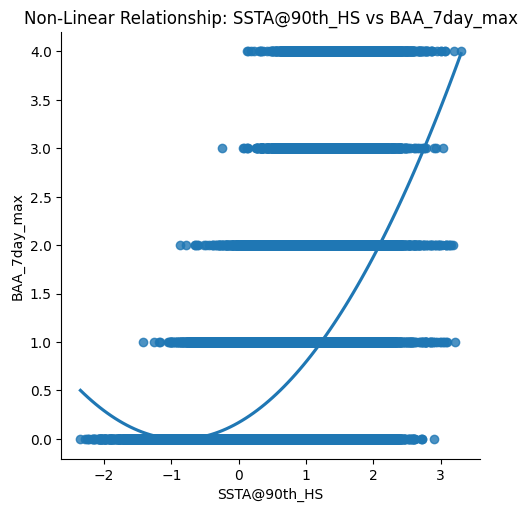

In [26]:
# https://seaborn.pydata.org/generated/seaborn.lmplot.html
sns.lmplot(data=combined_regions_df, x='SSTA@90th_HS', y='BAA_7day_max', order=2, ci=None)
plt.title('Non-Linear Relationship: SSTA@90th_HS vs BAA_7day_max')
plt.show()

***Non-Linear Confirmed!***

This confirms our hypothesis on it being a non-linear relationship. We seem to be witnessing a quadratic like curve where the vertex of the curve seems to sit at the value around -0.8 is our guess. What this directly translates too is that the severity level of the coral bleaching seems to actually increase at an exponential rate once passing an SSTA value of 0

Let's take a further look for all values and take this opportunity to graph the relationships for each column individually, each in comparison to investigate their relationships with the BAA

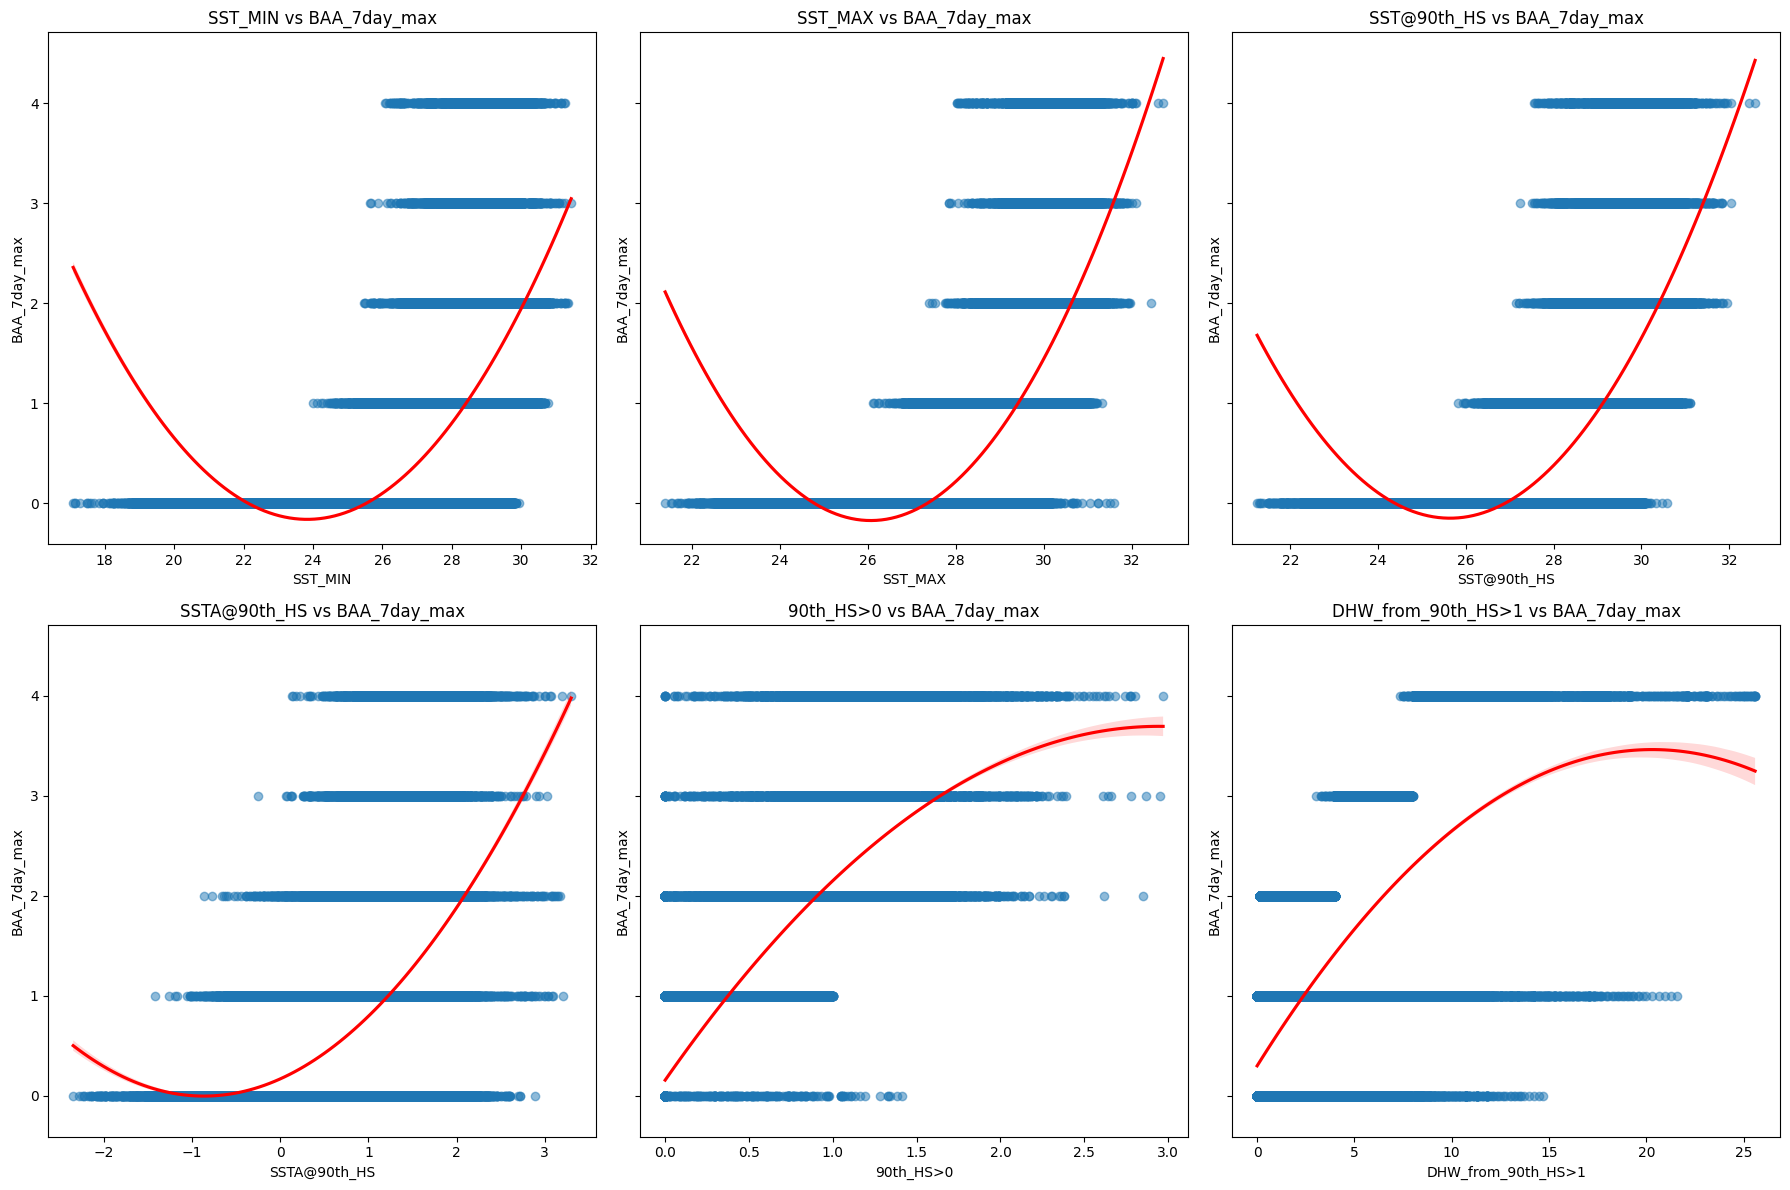

In [27]:
variables_to_test = ['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', '90th_HS>0', 'DHW_from_90th_HS>1']

fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

axes = axes.flatten()

for i, var in enumerate(variables_to_test):
    sns.regplot(
        data=combined_regions_df,
        x=var,
        y='BAA_7day_max',
        order=2,
        ax=axes[i],
        scatter_kws={'alpha': 0.5},
        line_kws={'color': 'red'}
    )
    axes[i].set_title(f'{var} vs BAA_7day_max')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('BAA_7day_max')

plt.tight_layout()
plt.show()

#### Key Findings & Takeaways

Let’s go through these one by one:

 - ***SST_MIN*** - The relationship is positive quadratic, meaning that both low and high minimum SST’s can lead to higher bleaching severity. We can see from its vertex that at approximately 24°C, we witness the most stability.

 - ***SST_MAX*** - As expected very similar positive quadratic relationship where roughly 26°C shows the sweet spot of lowest BAA severity

 - ***SST@90th_HS*** - Positive quadratic. The BAA severity seems to spike when the 90th percentile SST is either unusually below or above roughly 25°C

 - ***SSTA@90th_HS*** - As already seen, bleaching severity rises exponentially as the SSTA surpasses O°C. This confirms that warmer-than-usual conditions are a major driver of bleaching risk and is a huge factor for us.

 - ***90th_HS > 0*** - Here, we can see a different pattern than previously observed. The relationship curves upward sharply as daily hotspot values rise above a certain HS value. This is expected as we are looking at the the threshold value and we are sort of looking at the inverse here to the previous values showing that passing threshold values immediately accelerates BAA severity risks.

 - ***DHW_from_90th_HS > 1*** - Again, similar to the HS > 0, we are measuring thresholds here so the bleaching severity grows with accumulated heat stress (DHW - Degree Heating Weeks). We can say from this that heat stress matters a lot until it reaches a certain point shown to be around the 15 - 20 °C range

### Sub-Section 2.5: Multi-Regional Time-Series Analysis



Last but not least, we have made a lot of discovery outlining the non-linear relationship to be the most important out of them all. We should do some time-series analysis, more as a confirmation step, to see whether the time lags that we found in the Single-Set Analysis also apply at a global scope. 

We also want to compare them to the global scope and see if what we found earlier also applies to a multi-regional level, and if not, do we see any differences across the differences regions and stations in terms of BAA severity prediction delays.#

Let’s just get started by quickly grouping by dates again for ease on plotting visuals:

In [28]:
combined_regions_df = combined_regions_df.sort_values('Date')

Great, now we can plot:

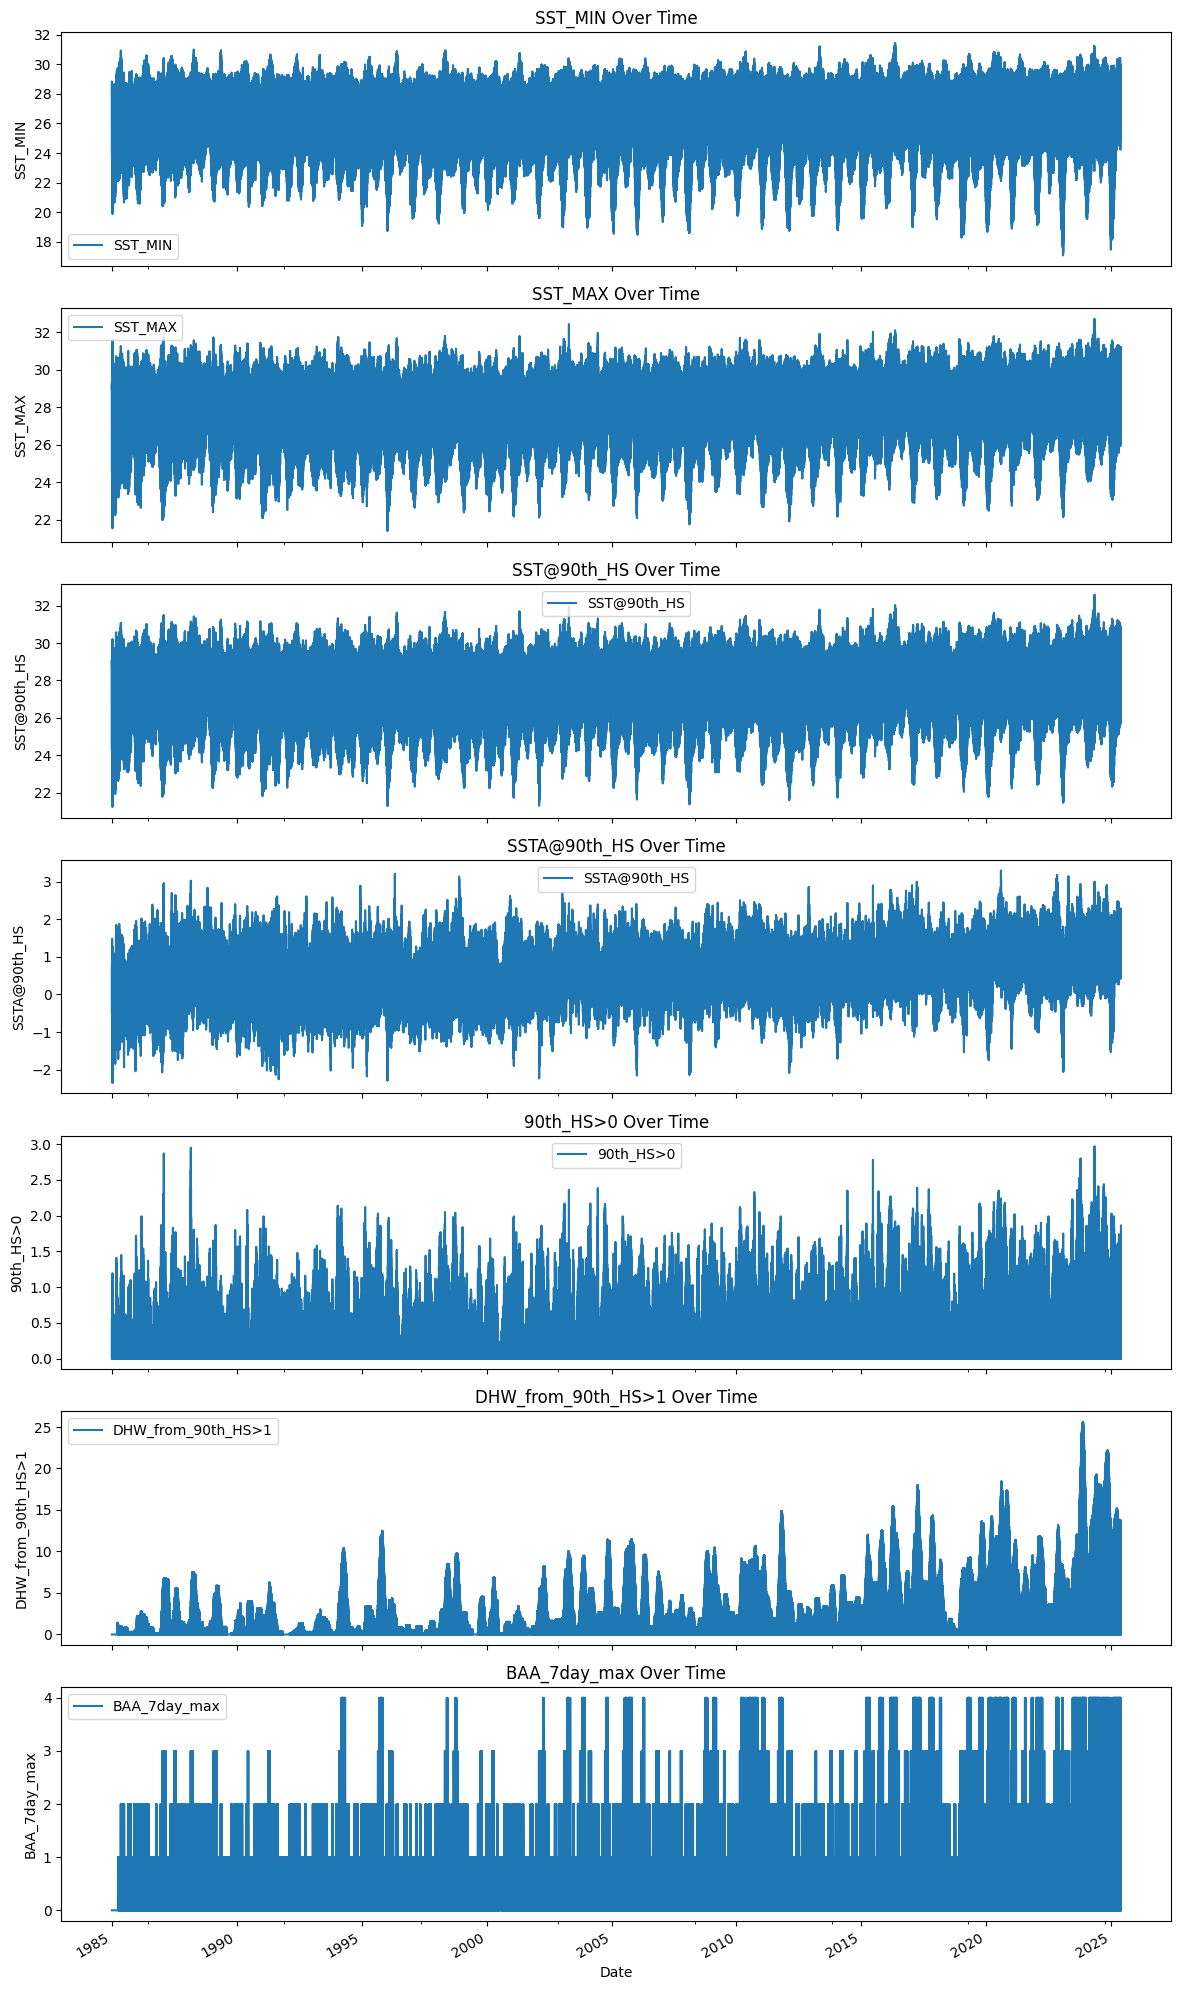

In [29]:
variables_to_plot = ['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', '90th_HS>0', 'DHW_from_90th_HS>1', 'BAA_7day_max']

fig, axes = plt.subplots(len(variables_to_plot), 1, figsize=(12, 20), sharex=True)

for i, var in enumerate(variables_to_plot):
    combined_regions_df.plot(x='Date', y=var, kind='line', ax=axes[i])
    axes[i].set_title(f'{var} Over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

First look shows us similar pattern results to when we first executed our Single-Set Time-Series Analysis. The reason for this plot was rather just to take a quick glance at the time series pattern in comparison to what we observed during the Single-Set Analysis which reveals to us fairly similar patterns across the different values within the 40 year time span till the present.

It would be useful to look into some more insightful graphs and statistics. Let’s try plotting the time lags for each values against the cross-correlation again similar to how we graphed them before:

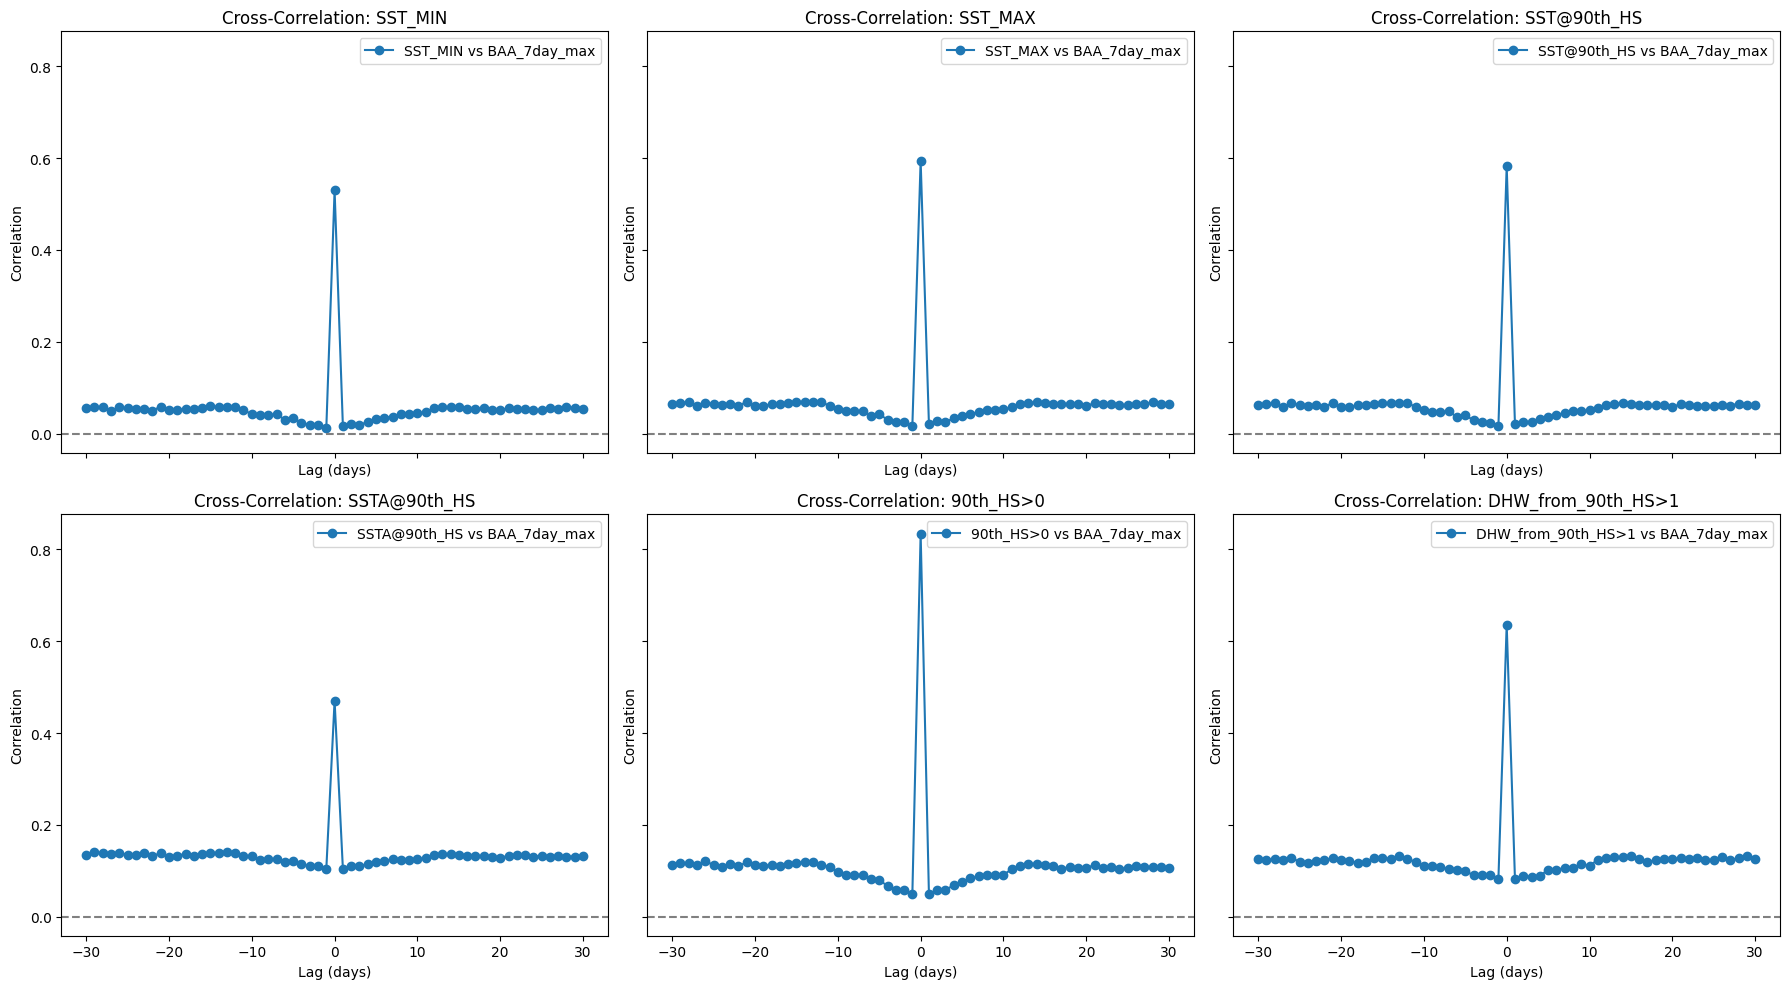

In [30]:
variables = ['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', '90th_HS>0', 'DHW_from_90th_HS>1']

lags = np.arange(-30, 31)  # Test lags from -30 to +30 days
baa_7day_series = combined_regions_df['BAA_7day_max'].fillna(0)

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, var in enumerate(variables):
    series = combined_regions_df[var].fillna(0)
    cross_corr = [series.corr(baa_7day_series.shift(lag)) for lag in lags]
    
    axes[i].plot(lags, cross_corr, marker='o', label=f'{var} vs BAA_7day_max')
    axes[i].set_title(f'Cross-Correlation: {var}')
    axes[i].set_xlabel('Lag (days)')
    axes[i].set_ylabel('Correlation')
    axes[i].axhline(0, color='gray', linestyle='--')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [31]:
for var in variables:
    series = station_df[var].fillna(0)
    cross_corr = [series.corr(baa_7day_series.shift(lag)) for lag in lags]
    max_corr = max(cross_corr, key=abs)  
    optimal_lag = lags[cross_corr.index(max_corr)]
    print(f"Variable: {var}, Max Correlation: {max_corr:.3f}, Optimal Lag: {optimal_lag} days")

Variable: SST_MIN, Max Correlation: -0.669, Optimal Lag: 0 days
Variable: SST_MAX, Max Correlation: -0.641, Optimal Lag: 0 days
Variable: SST@90th_HS, Max Correlation: -0.653, Optimal Lag: 0 days
Variable: SSTA@90th_HS, Max Correlation: -0.251, Optimal Lag: 0 days
Variable: 90th_HS>0, Max Correlation: -0.238, Optimal Lag: 0 days
Variable: DHW_from_90th_HS>1, Max Correlation: -0.225, Optimal Lag: 0 days


Something is wrong. Clearly, it can not be possible to have 0 time lag on all values. 

The 0 log here for all the cross-correlation can likely be explained by the regional difference, and the time zones. It is most likely just happening because the time zones are different and we do not have a unified time zone between. 

We can quickly confirm by separating the set and mapping the cross correlation by station instead and try to find them individually so that they are not effecting by the time zones:

In [32]:
stations = combined_regions_df['Station'].unique()

for station in stations:
    station_df = combined_regions_df[combined_regions_df['Station'] == station]
    baa_7day_series = station_df['BAA_7day_max'].fillna(0)
    
    print(f"Station: {station}")
    for var in variables:
        series = station_df[var].fillna(0)
        cross_corr = [series.corr(baa_7day_series.shift(lag)) for lag in lags]
        max_corr = max(cross_corr, key=abs)
        optimal_lag = lags[cross_corr.index(max_corr)]
        print(f"  Variable: {var}, Max Correlation: {max_corr:.3f}, Optimal Lag: {optimal_lag} days")

Station: Far Northern GBR
  Variable: SST_MIN, Max Correlation: 0.699, Optimal Lag: -4 days
  Variable: SST_MAX, Max Correlation: 0.706, Optimal Lag: -4 days
  Variable: SST@90th_HS, Max Correlation: 0.716, Optimal Lag: -4 days
  Variable: SSTA@90th_HS, Max Correlation: 0.465, Optimal Lag: -3 days
  Variable: 90th_HS>0, Max Correlation: 0.866, Optimal Lag: -4 days
  Variable: DHW_from_90th_HS>1, Max Correlation: 0.818, Optimal Lag: 28 days
Station: Northern GBR
  Variable: SST_MIN, Max Correlation: 0.652, Optimal Lag: -4 days
  Variable: SST_MAX, Max Correlation: 0.698, Optimal Lag: -4 days
  Variable: SST@90th_HS, Max Correlation: 0.698, Optimal Lag: -3 days
  Variable: SSTA@90th_HS, Max Correlation: 0.427, Optimal Lag: -3 days
  Variable: 90th_HS>0, Max Correlation: 0.851, Optimal Lag: -4 days
  Variable: DHW_from_90th_HS>1, Max Correlation: 0.786, Optimal Lag: 30 days
Station: Samoas
  Variable: SST_MIN, Max Correlation: 0.762, Optimal Lag: -3 days
  Variable: SST_MAX, Max Correlati

Perfect, we were correct as the time lag shows individually non-zero values when broken down to a station level. We also first tested at a regional level, where we still saw 0 lag which made sense but will not include in the notebook to save us some space!

Furthermore, to make this data actually usable, we can take the averages. From this, we can get this into some more valuable as we generalise the lag to the average:

In [33]:
results = {var: {'avg_corr': [], 'avg_lag': []} for var in variables}

for station in stations:
    station_df = combined_regions_df[combined_regions_df['Station'] == station]
    baa_7day_series = station_df['BAA_7day_max'].fillna(0)
    
    for var in variables:
        series = station_df[var].fillna(0)
        cross_corr = [series.corr(baa_7day_series.shift(lag)) for lag in lags]
        max_corr = max(cross_corr, key=abs)
        optimal_lag = lags[cross_corr.index(max_corr)]
        
        results[var]['avg_corr'].append(max_corr)
        results[var]['avg_lag'].append(optimal_lag)

averages = {var: {'avg_corr': np.mean(results[var]['avg_corr']),
                  'avg_lag': np.mean(results[var]['avg_lag'])} for var in variables}

for var, stats in averages.items():
    print(f"Variable: {var}, Average Correlation: {stats['avg_corr']:.3f}, Average Lag: {stats['avg_lag']:.1f} days")

Variable: SST_MIN, Average Correlation: 0.702, Average Lag: -3.6 days
Variable: SST_MAX, Average Correlation: 0.715, Average Lag: -3.7 days
Variable: SST@90th_HS, Average Correlation: 0.717, Average Lag: -3.5 days
Variable: SSTA@90th_HS, Average Correlation: 0.473, Average Lag: -3.2 days
Variable: 90th_HS>0, Average Correlation: 0.834, Average Lag: -4.2 days
Variable: DHW_from_90th_HS>1, Average Correlation: 0.741, Average Lag: 29.0 days


***Takeaway***

Not much to takeaway here apart from the fact that the results confirm our earlier findings from the single-station analysis. We see consistent time lag numbers and strong correlations across variables at a multi-regional level similar to the station-level for each individual variable to BAA severity. This reinforces the reliability of these predictors for modeling coral bleaching severity.

### Multi-Set Analysis Conclusion

As seen from this section of our EDA procedure, we expanded the scope of the analysis to a global, multi-regional scale, allowing us to build on top of the  insights that we gained from the single-station analysis.

In conclusion, we first confirmed that many of the strong relationships observed at the station level, like the correlations between SST metrics and bleaching severity, were also found to be true across different regions. This consistency not only. Provides further evidence to back our claims made from the SingleSet analysis but also displays the reliability of the NOAA dataset. 

Additionally, we discovered important differences at a regional level where differences in temperature fluctuations between seasonal changes seemed to have an influence on the BAA severity risk scores. This was seen when we compared the distributions of SST’s between the regions and confirmed our hypothesis within the seasonal temperature fluctuation distributions.

Not only that, we also confirmed that the Fall season consistently showed the most significant SST fluctuations, making it a critical time of the year to analyse for bleaching risks. 

That then moved us to question the relationships between values and the BAA severity levels, making us believe that we were no longer working within a linear space. We were able to confirm this by graphing the relationships between SST and bleaching severity using seaborns lmplot() function. It was during this process that we saw exponential increases in severity once certain thresholds were crossed for all values. 

Finally, the time-series analysis from this section confirmed the time lags and correlations seen in the Single-Set Analysis to be true. We managed to show consistent predictive patterns across regions in terms of seeing early signs of coral bleaching behaviour. 

## Feature Set Engineering

This section enters the post EDA phase and covers the data preparation phase for our project where we do some feature engineering and prepare the dataset for our model training.

### Sub Sections:

- Sub-section 3.1: Engineering features

- Sub-section 3.2: Pre-Train Data Processing

- Sub-section 3.3: Splitting & Scaling

### Sub-section 3.1: Engineering Features

Before we continue onto further steps of feature engineering then model testing & selection, let's take a step back and recap on our findings so far. 

We have managed to determine:
- We've had a look into correlations and what the strong predictors are. This turned out to be the 90th_HS>0, and the DHW_from_90th_HS>1 values.

- We found time lagged relationships between the different columns and the bleaching levels. This is crucial to feed the model as it helps the model understand how certain values can be seen as early warning signs and that the pinpointing the time lag will actually help the model understand bleaching risks from an earlier stage and possibly make forecasts, potentially opening us up to the ARIA model domain 

- Most importantly, we also confirmed that we are working in a Non-linear space where passing certain SST & SSTA thresholds can cause growth in bleaching severity at an exponential rate.

- Threshold values. In relation to the previous point of defining a non-linear space, it's important to note and target certain values that we can treat as thresholds since we understand that passing these values will cause exponential increases in bleach risks

- Last but not least: Seasonal Patterns. We managed to determine that changes in the season caused fluctuations in SST and when we particularly looked into the seasonal analysis between both the single set, and multi-set evaluations, it was apparent that the seasonal patterns also played a role in our SST fluctuations which we could relate to the BAA changes


Considering all of these points, we have decided to move forward with creating 5 new features:

- Lagged features for catering time lags

- Threshold features for determining key threshold values points

- Polynomial Features

- Interaction terms

#### Feature 1 <> Lagged Features

***New Values***: SST_MIN_lag4, SST_MAX_lag4, SST@90th_HS_lag4, SSTA@90th_HS_lag4, 90th_HS>0_lag4, DHW_from_90th_HS>1_lag29

This feature represents the time lag values for all the values from where we computed the mean lag days and round them to the nearest integer.

We include these lagged features in order to help the model understand how past values and influence current bleaching severity

In [34]:
combined_regions_df['SST_MIN_lag_back_4'] = combined_regions_df['SST_MIN'].shift(-4)
combined_regions_df['SST_MAX_lag_back_4'] = combined_regions_df['SST_MAX'].shift(-4)
combined_regions_df['SST@90th_HS_lag_back_4'] = combined_regions_df['SST@90th_HS'].shift(-4)
combined_regions_df['SSTA@90th_HS_lag_back_3'] = combined_regions_df['SSTA@90th_HS'].shift(-3)
combined_regions_df['90th_HS>0_lag_back_4'] = combined_regions_df['90th_HS>0'].shift(-4)
combined_regions_df['DHW_from_90th_HS>1_lag_forward_29'] = combined_regions_df['DHW_from_90th_HS>1'].shift(29)

#### Feature 2 <> Threshold Features

***New Values***: SSTA_above_threshold, 90th_HS_above_threshold

A binary (0 = negative, 1 = positive) computed feature value indicating whether SSTA@90th_HS exceeds 0 and similarly for when the 90th_HS>0 is above 0.

As stated, we discovered that crossing certain thresholds is one of, if not the biggest identifier for extreme temperature events that could lead to coral bleaching.

In [35]:
combined_regions_df['SSTA_above_threshold'] = (combined_regions_df['SSTA@90th_HS'] > 0).astype(int)
combined_regions_df['90th_HS_above_0'] = (combined_regions_df['90th_HS>0'] > 0).astype(int)

#### Feature 3 <> Polynomial / Quadratic Feature

***New Values***: SSTA_squared

The square of SSTA@90th_HS for capturing the non-linear simply caputring the polynomial nature in our BAA severity relationship against the SST Anomaly

We saw that a positive quadratic relationship between the BAA vs SSTA@90th_HS value, so we can express this as:

- y = ax^2 + bx + c as seen in the quadratic formula when expressing polynomials to the second degree (parabolas) where x = SSTA and y = BAA_7

The ax^2 term captures the degree of the curve where we can capture the acceleration of risk as a result of the rise of the temperature.

In [36]:
combined_regions_df['SSTA_squared'] = combined_regions_df['SSTA@90th_HS'] ** 2

#### Feature 4 <> Interaction Term

***New Values***: SSTA_DHW_interaction

Here we simply multiply the SSTA@90th_HS and DHW_from_90th_HS>1

Now, this might be a bit counter-intuitive at first on why we do this but let me explain. 

When we discovered that we were working in non-linear space within the sub-section 2.4, we saw that the SST anomalies (rare SST events) had a polynomial relationship with the BAA severity levels. If we think about it, a single spike in the SST will alone will likely ***not*** cause a sudden increase in the bleaching severity levels, but you know what will? If the SST anomaly is showing a high score or passed its threshold for an ***extended period of time***. 

This is where we bring the DHW_from_90th_HS>1 into play as it is capturing the Degree Heating Weeks which essentially measures the ***accumulated heat stress over time***. What I am basically trying to say here is that if we multiply both the SSTA values together with the DHW, we are able to capture SST the essence of un-regularly warm temperatures over an extended period of time which obviously will very likely lead to the BAA levels increasing.

In [37]:
combined_regions_df['SSTA_DHW_interaction'] = combined_regions_df['SSTA@90th_HS'] * combined_regions_df['DHW_from_90th_HS>1']

### Sub-Section 3.2: Pre-Train Data Processing

A rather shorter sub-section here, but still important. We will narrate the decisions here rather than give detailed explanations as it is unnecessary to do so and is likely a lot more suitable to just see the practical results:

Confirm again that we no missing values and check the columns that are currently present

In [38]:
print(combined_regions_df.isna().sum())
combined_regions_df = combined_regions_df.dropna()

YYYY                                  0
MM                                    0
DD                                    0
SST_MIN                               0
SST_MAX                               0
SST@90th_HS                           0
SSTA@90th_HS                          0
90th_HS>0                             0
DHW_from_90th_HS>1                    0
BAA_7day_max                          0
Station                               0
Region                                0
Latitude                              0
Longitude                             0
Date                                  0
Season                                0
SST_MIN_lag_back_4                    4
SST_MAX_lag_back_4                    4
SST@90th_HS_lag_back_4                4
SSTA@90th_HS_lag_back_3               3
90th_HS>0_lag_back_4                  4
DHW_from_90th_HS>1_lag_forward_29    29
SSTA_above_threshold                  0
90th_HS_above_0                       0
SSTA_squared                          0


Lets drop the 'Date' Column that we where using from earlier since it was for EDA purposes only and will get in the way on top of the YYYY, MM, DD columns when we train our model. We leveraged the Date column earlier and was crucial for our time-series analysis along with other parts of the EDA, but will just get in our way for the model training:

In [39]:
combined_regions_df = combined_regions_df.drop(columns=['Date', 'Station', 'Latitude', 'Longitude'])
print(combined_regions_df.head())

        YYYY  MM  DD  SST_MIN  SST_MAX  SST@90th_HS  SSTA@90th_HS  90th_HS>0  \
73764   1985  01  03    25.88    27.98        27.78        0.3132        0.0   
147527  1985  01  03    26.85    27.08        26.98       -0.2174        0.0   
103268  1985  01  03    26.09    26.67        26.63       -0.5723        0.0   
44259   1985  01  03    28.24    29.01        28.92        0.1529        0.0   
59011   1985  01  03    24.06    24.77        24.63       -0.3471        0.0   

        DHW_from_90th_HS>1  BAA_7day_max  ... SST_MIN_lag_back_4  \
73764                  0.0             0  ...              24.06   
147527                 0.0             0  ...              26.07   
103268                 0.0             0  ...              28.80   
44259                  0.0             0  ...              25.69   
59011                  0.0             0  ...              23.48   

       SST_MAX_lag_back_4  SST@90th_HS_lag_back_4  SSTA@90th_HS_lag_back_3  \
73764               24.77       

Quickly convert the YYYY, MM, and DD columns to integer types as they where objects in the initial pull:

In [40]:
combined_regions_df['YYYY'] = combined_regions_df['YYYY'].astype(int)
combined_regions_df['MM'] = combined_regions_df['MM'].astype(int)
combined_regions_df['DD'] = combined_regions_df['DD'].astype(int)

I want to also one hot encode the Station and Region because they are categorical values and ofcourse, our model can not learn from non-numerical data points. We don't want to confuse our model! 

In [ ]:
combined_regions_df[['Season', 'Region']] = combined_regions_df[['Season', 'Region']].fillna('Unknown')
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(combined_regions_df[['Season', 'Region']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Season', 'Region']))
encoded_df.index = combined_regions_df.index
combined_regions_df = pd.concat([combined_regions_df.drop(columns=['Season', 'Region']), encoded_df], axis=1)

print(combined_regions_df.dtypes)

YYYY                                   int64
MM                                     int64
DD                                     int64
SST_MIN                              float64
SST_MAX                              float64
SST@90th_HS                          float64
SSTA@90th_HS                         float64
90th_HS>0                            float64
DHW_from_90th_HS>1                   float64
BAA_7day_max                           int64
SST_MIN_lag_back_4                   float64
SST_MAX_lag_back_4                   float64
SST@90th_HS_lag_back_4               float64
SSTA@90th_HS_lag_back_3              float64
90th_HS>0_lag_back_4                 float64
DHW_from_90th_HS>1_lag_forward_29    float64
SSTA_above_threshold                   int64
90th_HS_above_0                        int64
SSTA_squared                         float64
SSTA_DHW_interaction                 float64
Season_Fall                          float64
Season_Spring                        float64
Season_Sum

Beautiful, we see all the columns that we want and in the perfect data types. We are very ready to start training some regression models with one step left.

### Sub-Section 3.4: Splitting & Scaling

Final Sub-Section before we get to the model training, we will use this step in order to split our data set between the training set and testing set, then create two new variables where we scale axis the X-and only the x-axis.

***Splitting*** 

First we need to identify our target variable, which is of course going to be the ‘BAA_7day_max’ as we want to predict the bleaching severity levels. Then we just simply need to simply keep the BAA column in the testing set while dropping it from the training set as the training set will be making the predictions:

In [ ]:
y = combined_regions_df['BAA_7day_max'] 
X = combined_regions_df.drop(columns=['BAA_7day_max'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (141598, 27)
Testing set size: (35400, 27)


***Scaling***

Now after scaling the dataset, we can create some new scaled variables for later use during the training phase. 

We will only be scaling the X axis on the training and test sets We do this because we clearly do not want to scale the target value (y) as the whole point of is to predict outcomes from the computing on the features which are the X-axis. Scaling is completely irrelevant for the outcome values

Since we are using supervised learning in the regression category, it will be dependant on the model we will be training on whether they use the scaled data or not. To be specific, we will be using the scaled data for training our:

- ***Neural Network*** - A NN is usually sensitive to the scale of the features. We tried a couple iterations with the non-scaled data and saw a negative r^2 value! After using the scaled data, we saw a much more realistic, expected result

- ***K-Nearest Neighbors*** - Since we already know that the KNN (smaller version to the SVM) uses the Euclidean distance within a n-dimensional space, it was already known knowledge for us that it was pretty important to also use the scaled features so the distances where equally calculated


The models that we used the standard values on and not scaled:

- ***Random Forest*** - The random forest uses a tree-based structure where the model makes decisions based on thresholds. Therefore since we are splitting data based on features rather than distance, the scale does not matter.

- ***XGBoost*** - Similar to it’s sibling, the XGBoost is a tree-based model on a larger scale where it is insensitive to scaled values the data is split on features aswell rather than distance

In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Supervised Learning

The final destination of our journey, training our supervised learning model. In this last section of our notebook, we will be going through a thorough model analysis that where carefully picked to suit our needs. After testing different solutions we find the best model fit, train our hyper-parameters for our model and export the model using joblib in preparation for application deployment.

### Sub Sections:

- Sub-section 4.1: Model comparisons

- Sub-section 4.2: Cross-Validation of Models

- Sub-section 4.3: Hyper-Parameter Tuning

- Sub-section 4.4: Manual Model Test

- Sub-section 4.5: Model Deployment

### Sub-Section 4.1: Model Comparisons

As already mentioned slightly from out data split explanations the regression models that we will be testing and comparing are:

- ***Random Forest Regressor*** - This was our first choice as it is known for its ability on handling non-linear relationships and great use cases in handling complex feature interactions.

- ***XGBoost Regressor*** - A natural choice to follow up on a Random Forest Regressor as it is has high predictive accuracy and known for handling large datasets quite well.

- ***K-Nearest Neighbors (KNN)*** - We have included this because of it’s simplicity and effectiveness in capturing relationships between data points, with our scaled values this has potential to give us some good results.

- ***Multi-Layer Perceptron (MLP)*** Another choice that we added for its skills in modelling complex, non-linear relationships we where also generally curious to see how our dataset would perform in a neural network architecture.

We will run them one by one and be comparing the metrics of: Root Mean Squared Error (RMSE) and R² score on both training and testing sets as we they are regression models. 

Hopefully, this will help us determine which model provides the best balance between accuracy and generalisation for our BAA severity predictions!

#### Model 1: Random Forest

In [ ]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print(f"Random Forest Training RMSE: {train_rmse:.2f}")
print(f"Random Forest Testing RMSE: {test_rmse:.2f}")
print(f"Random Forest R^2 Score: {r2:.2f}")

Training RMSE: 0.10
Testing RMSE: 0.26
R^2 Score: 0.90


***Results <> Random Forest Regressor***

Training RMSE: 0.10 – This shows us excellent fit on our training data

Testing RMSE: 0.26 – Fairly low error on the test(unseen data), shows decent generalization.

R² Score: 0.90 – High predictive accuracy score of 90%

#### Model 2: XGBoost

In [ ]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print(f"XGBoost - Training RMSE: {train_rmse:.2f}, Testing RMSE: {test_rmse:.2f}, R^2: {r2:.2f}")

XGBoost - Training RMSE: 0.24, Testing RMSE: 0.28, R^2: 0.90


***Results <> XGBoost***

Training RMSE: 0.24 – Higher error compared to our RFR but still not a bad score

Testing RMSE: 0.28 – Again not much difference in comparison compares to our RFR, shows similar levels generalisation.

R² Score: 0.90 – Same score in comparison to our RFR. High predictive accuracy score of 90%

#### Model 3: KNN

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

y_pred_train_knn = knn_model.predict(X_train_scaled)
y_pred_test_knn = knn_model.predict(X_test_scaled)

train_rmse_knn = np.sqrt(mean_squared_error(y_train, y_pred_train_knn))
test_rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_test_knn))
r2_knn = r2_score(y_test, y_pred_test_knn)

print(f"KNN - Training RMSE: {train_rmse_knn:.2f}, Testing RMSE: {test_rmse_knn:.2f}, R^2: {r2_knn:.2f}")

KNN - Training RMSE: 0.27, Testing RMSE: 0.33, R^2: 0.85


***Results <> KNN***

Training RMSE: 0.27 – Higher error shown here in comparison the previous two models

Testing RMSE: 0.33 – Even higher levels of error on the unseen data in comparison the performance of our other models.

R² Score: 0.85 – Much lower accuracy score here where we seem the model only predicting 85% accuracy. It is still a reasonable score

#### Model 4: MLP

In [ ]:
mlp_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

y_pred_train_mlp = mlp_model.predict(X_train_scaled)
y_pred_test_mlp = mlp_model.predict(X_test_scaled)

train_rmse_mlp = np.sqrt(mean_squared_error(y_train, y_pred_train_mlp))
test_rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_test_mlp))
r2_mlp = r2_score(y_test, y_pred_test_mlp)

print(f"MLPRegressor - Training RMSE: {train_rmse_mlp:.2f}, Testing RMSE: {test_rmse_mlp:.2f}, R^2: {r2_mlp:.2f}")

MLPRegressor - Training RMSE: 0.27, Testing RMSE: 0.29, R^2: 0.88


***Results <> MLP***

Training RMSE: 0.27 – Same error score as the KNN, shows decent fitting

Testing RMSE: 0.29 – Lower levels showing better generalisation in comparison to our KNN results and similar levels to our RFR and XGBoost.

R² Score: 0.88 – Slightly higher accuracy in comparison to our kNN model but still outclassed by the RFR and XGBoost.

### Sub-Section 4.2: Cross-Validation of Models

So far it is apparent that the Random Forest Regressor is showing superior scores and likely being the best model of choice for us here. 

Although, we have some promising results, it would be good to run some cross-validation analysis of the models over at least 5 folds, so that we can can draw a concrete conclusion here and decide and absolute winner.

We can simply do this leveraging sklearn metrics cross_val_score() functions:

In [ ]:
rf_model = RandomForestRegressor(random_state=42)
knn_model = KNeighborsRegressor(n_neighbors=5)
mlp_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
xgb_model = XGBRegressor(random_state=42)

cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_knn = cross_val_score(knn_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_mlp = cross_val_score(mlp_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

cv_rmse_rf = np.sqrt(-cv_scores_rf)
cv_rmse_knn = np.sqrt(-cv_scores_knn)
cv_rmse_mlp = np.sqrt(-cv_scores_mlp)
cv_rmse_xgb = np.sqrt(-cv_scores_xgb)

print("Cross-Validation RMSE:")
print(f"Random Forest - Mean CV RMSE: {cv_rmse_rf.mean():.2f}")
print(f"KNN - Mean CV RMSE: {cv_rmse_knn.mean():.2f}")
print(f"MLPRegressor - Mean CV RMSE: {cv_rmse_mlp.mean():.2f}")
print(f"XGBoost - Mean CV RMSE: {cv_rmse_xgb.mean():.2f}")

Cross-Validation RMSE:
Random Forest - Mean CV RMSE: 0.28
KNN - Mean CV RMSE: 0.34
MLPRegressor - Mean CV RMSE: 0.29
XGBoost - Mean CV RMSE: 0.28


The winner is clear: The Random Forest Regressor wins with the lowest RMSE mean score of 0.28 and a r^2 value of 0.90 showing a 90% accuracy in predicting coral bleach severity based on our feature inputs. 

Now that we have chosen the most suitable model for our use case, we can move onto the hyper parameter tuning where we can try a series of parameters and utilise GridSearch in order to run folds and find the best parameters for our use case!

### Sub-Section 4.3: Hyper-Parameter tuning

The reason for why we tune is that we simply want to find the best parameter for our regressor model that allows us to minimize the MSE while making sure that the model is still generalizing well.

First, we need to determine what hyper-parameters that are optimal for our use case, it's important to make a careful selection before we start running the tuning as this can be quite lengthy depending and how much tuning you are doing and what specs you are running.

***Defining Parameters***

When we choose the parameters to tune for, they are quite usually defined for the model that we are working for. 

Since our model selection in the end fell under the Random Forest Regressor category, I have decided to go with these parameters to begin with:

- ***n_estimators***: Allows us to tune the number of boosting stages (trees).

- ***max_depth***: Maximum depth of each tree.

- ***min_samples_split***: Minimum samples required to split a node.

- ***min_samples_leaf***: Minimum samples required in a leaf node.

- ***max_features***: This will determine the best number of features the model should use when looking for the best node split

- ***max_leaf_nodes*** - This will help us determine the maximum number of leaf nodes in the tree that is found to be optimal

When it comes to the options, lets start with the standard setup that will not take too much computational costs but also allows for us to cover a good ground for maximum optimisation:

In [66]:
param_grid = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [10, 20, 30], 
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 2],  
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [None, 50]  
}

With the the parameters defined, we can utilise GridSearchCV in order to run the model over the number of folds that we define and wait wait for it to compute the optimal hyper-parameters: 

In [68]:
rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {np.sqrt(-grid_search.best_score_):.2f}")

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   9.8s
[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   9.7s
[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   9.9s
[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   9.9s
[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   9.9s
[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   9.9s
[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_samp

Outputs show the optimal parameters:

- ***max_depth***: 30
- ***max_features***: 'sqrt'
- ***max_leaf_nodes***: None
- ***min_samples_leaf***: 1
- ***min_samples_split***: 2
- ***n_estimators***: 300

Great, lets finally test our model with these optimally found hyper-parameters

In [51]:
best_rf_model = RandomForestRegressor(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    random_state=42
)

best_rf_model.fit(X_train, y_train)

y_pred_train = best_rf_model.predict(X_train)
y_pred_test = best_rf_model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Training RMSE: 0.11
Testing RMSE: 0.26
R² Score: 0.90


***Model Conclusion***

Unfortunately the tuned results do not show much of a difference for us. We can say that this is probably because 

Either way, the model is well-trained and generalises effectively, as we can see from our low RMSE and high R² score. Not only that, we can confidently say that the small gap between training and testing RMSE shows the model is not overfitting and performs consistently on both the training and test datasets.

This result confirms that the Random Forest Regressor is a good choice for our prediction projects, and the model is ready for deployment!

### Sub-Section 4.4: Manual Model Test

Out of curiosity, It would be nice to run a manual test so that we can confirm our model is working as it should be with the correct inputs and try calculating a BAA severity score from some manual input:

In [52]:
sample_data = {
    'YYYY': [2025],
    'MM': [5],
    'DD': [25],
    'SST_MIN': [27.1],
    'SST_MAX': [29.95],
    'SST@90th_HS': [29.0],
    'SSTA@90th_HS': [1.49],
    '90th_HS>0': [0.5],
    'DHW_from_90th_HS>1': [2.3],
    'SST_MIN_lag_back_4': [26.5],
    'SST_MAX_lag_back_4': [29.5],
    'SST@90th_HS_lag_back_4': [28.8],
    'SSTA@90th_HS_lag_back_3': [1.45],
    '90th_HS>0_lag_back_4': [0.4],
    'DHW_from_90th_HS>1_lag_forward_29': [2.1],
    'SSTA_above_threshold': [0],
    '90th_HS_above_0': [0],
    'SSTA_squared': [1.49**2],
    'SSTA_DHW_interaction': [1.49 * 2.3],
    'Season_Fall': [0], 
    'Season_Spring': [0],
    'Season_Summer': [1],
    'Season_Winter': [0],
    'Region_Caribbean': [0], 
    'Region_Great Barrier Reef': [1],
    'Region_Polynesia': [0],
    'Region_South Asia': [0],
}

sample_df = pd.DataFrame(sample_data)

Now just run against our tuned and trained model:

In [53]:
sample_data_scaled = scaler.transform(sample_df)
sample_prediction = best_rf_model.predict(sample_data_scaled)

print(f"Predicted BAA_7day_max (Bleaching Severity): {sample_prediction[0]:.2f}")

Predicted BAA_7day_max (Bleaching Severity): 0.70


/Users/ken/Desktop/self-repositories/coral-bleach-predictor/myvenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


And there we see it, our model was able to successfully predict a BAA severity score of approximately 0.70, if we round that to the an integer we get a severity score of 1

### Sub-Section 4.5: Model Deployment

Great, all that is left to do is deploy our model. We can simply do this using a library called joblib. Lets pull this into a different directory within our project under /models and use it later for integration and application purposes:

In [ ]:
joblib.dump(best_rf_model, "../models/coral_bleaching_predictor.pkl")
joblib.dump(scaler, "../models/scaler.pkl")

print("Model and scaler saved successfully!")

Model and scaler saved successfully!


### Supervised Learning Conclusion

As a conclusion, we where able to successfully develop and evaluate a supervised learning model that predicts coral bleaching severity official NOAA dataset across 4 different regions pulling 3 stations each totalling an approximate count of 177,000 rows of data. 

After comparing 4 different regression models, including the Random Forest Regressor, XGBoost, K-Nearest Neighbors (KNN), and Multi-Layer Perceptron (MLP), the Random Forest Regressor proved to be the best-performing model. It showed a strong balance between accuracy and generalization, achieving a high r^2 score of 0.90 and a low RMSE of 0.26 on the test set. 

Although our hyper-parameter tuning results did not show much improvement on the accuracy scores, we still managed to run an extended tuning session and find the the hypothetically best parameters for our model.